# Carys MPB1234
## Xiaonan Wang
## 02Mar2020

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


In [3]:
# read in metadata
# Since the metadata has been tidied up previously in R (Carys_MPB1234.R)
# Here I just the output from R
meta = pd.read_csv('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/MPB1234/MPB_data/MetaData/meta_MPB1234_combined.txt', delimiter='\t')
meta.index = meta['ID']
print(meta.shape)
display(meta.head(1))

(2250, 30)


Gottgens_ID_RBGxxx CRI_identifier CRI_run  \
ID                                                              
SLX.12981.i701_i502           RBG17407      SLX-12981     NaN   

                              Plate_number Position_in_96_well_plate_sorted  \
ID                                                                            
SLX.12981.i701_i502  Sort 11 Day 0 Plate 1                               A1   

                    Position_in_96_well_plate_RNA_seq FACs_index_data  \
ID                                                                      
SLX.12981.i701_i502                                A1             Yes   

                        Sample_name  \
ID                                    
SLX.12981.i701_i502  d0 CD34+ (S11)   

                                                               Details  \
ID                                                                       
SLX.12981.i701_i502  d0_mobilised_peripheral_blood_derived_CD34+ (S11)   

                    Cell_type_general  ...  \
ID                                     ...   
SLX.12981.i701_i502         mPB CD34+  ...   

                    Number_of_additional_lanes_ordered_i_e_repeats  Paid_Y_N  \
ID                                                                             
SLX.12981.i701_i502                                            NaN       NaN   

                    Invoice_number Price Cell_Type   Day  Condition    Plate  \
ID                                                                             
SLX.12981.i701_i502            NaN   NaN     CD34+  Day0         NT  Plate 1   

                     Batch                   ID  
ID                                               
SLX.12981.i701_i502     B1  SLX.12981.i701_i502  

[1 rows x 30 columns]

In [4]:
meta['con_comb'] = meta['Day'].astype(str)+'_'+meta['Cell_Type'].astype(str)+'_'+meta['Condition'].astype(str)
meta['con_comb'].value_counts().sort_index()

Day0_CD34+_NT          309
Day0_Empty_Empty        13
Day0_LT-HSC_NT         320
Day0_ST-HSC_Empty        1
Day0_ST-HSC_NT         305
Day0_nan_Empty           2
Day3_CD34+_GFP+PD-     164
Day3_CD34+_GFP-PD-      92
Day3_CD34+_NT          120
Day3_LT-HSC_GFP+PD+    116
Day3_LT-HSC_GFP+PD-    204
Day3_LT-HSC_GFP-PD+     48
Day3_LT-HSC_GFP-PD-    102
Day3_LT-HSC_NT         120
Day3_ST-HSC_GFP+PD-    142
Day3_ST-HSC_GFP-PD-     72
Day3_ST-HSC_NT         118
Day3_nan_Empty           2
Name: con_comb, dtype: int64

In [3]:
gtpfile = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/programs/Cellranger_RefGenome/Homo_sapians_GRCh38_ERCC92_GFP.gtf'
ftable_loc = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/MPB1234/MPB_data/features.tsv'
smqpp.generate_feature_table(gtpfile, ftable_loc)

In [4]:
Indir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/MPB1234/MPB_data/Count_files/'
folder_list = np.array(os.listdir(Indir))
folder_list = np.sort(folder_list)
print(folder_list)

['B1_count.txt' 'B2_count.txt' 'B3_count.txt' 'B4_count.txt']


In [5]:
# define QC thresholds
cutoff1 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(10**5.2),
           'fGenes:nTotal': 0.3,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.4
          }
cutoff2 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(10**5.2),
           'fGenes:nTotal': 0.3,
           'nHCGenes': 1000,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.4
          }
cutoff3 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(15000),
           'fGenes:nTotal': 0.1,
           'nHCGenes': 1000,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff4 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(100000),
           'fGenes:nTotal': 0.2,
           'nHCGenes': 1000,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff = [cutoff1, cutoff2, cutoff3, cutoff4]

B1_count.txt
Count table shape: (554, 65989)
Feature table shape:(65989, 2)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


mito_genes: ['MT-ND6', 'MT-CO2', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-ND3', 'MT-ND4', 'MT-ND1', 'MT-ATP6', 'MT-CO3', 'MT-TL1', 'MT-TF', 'MT-TV', 'MT-RNR2', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-TS1', 'MT-TD', 'MT-TK', 'MT-TG', 'MT-TR', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-TE', 'MT-TT', 'MT-TP', 'MT-RNR1', 'MT-ND4L', 'MT-ATP8']
Number of passed cells: 495
Number of failed cells: 59
B2_count.txt
Count table shape: (570, 65989)
Feature table shape:(65989, 2)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


mito_genes: ['MT-ND6', 'MT-CO2', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-ND3', 'MT-ND4', 'MT-ND1', 'MT-ATP6', 'MT-CO3', 'MT-TL1', 'MT-TF', 'MT-TV', 'MT-RNR2', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-TS1', 'MT-TD', 'MT-TK', 'MT-TG', 'MT-TR', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-TE', 'MT-TT', 'MT-TP', 'MT-RNR1', 'MT-ND4L', 'MT-ATP8']
Number of passed cells: 442
Number of failed cells: 128
B3_count.txt
Count table shape: (380, 65989)
Feature table shape:(65989, 2)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


mito_genes: ['MT-ND6', 'MT-CO2', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-ND3', 'MT-ND4', 'MT-ND1', 'MT-ATP6', 'MT-CO3', 'MT-TL1', 'MT-TF', 'MT-TV', 'MT-RNR2', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-TS1', 'MT-TD', 'MT-TK', 'MT-TG', 'MT-TR', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-TE', 'MT-TT', 'MT-TP', 'MT-RNR1', 'MT-ND4L', 'MT-ATP8']


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:171: RuntimeWarning: invalid value encountered in greater
  nHCGenes = np.sum(adata[:,~np.in1d(adata.var_names,mito_genes)].X.T*(10**6)/(nuclearCNT+1) > 10, axis=0)
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:195: RuntimeWarning: invalid value encountered in less
  failed.append(QCdata[k] < cutoff[k])
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:197: RuntimeWarning: invalid value encountered in greater
  failed.append(QCdata[k] > cutoff[k])


Number of passed cells: 212
Number of failed cells: 168


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:227: RuntimeWarning: invalid value encountered in greater
  adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1)


B4_count.txt
Count table shape: (746, 65989)
Feature table shape:(65989, 2)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


mito_genes: ['MT-ND6', 'MT-CO2', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-ND3', 'MT-ND4', 'MT-ND1', 'MT-ATP6', 'MT-CO3', 'MT-TL1', 'MT-TF', 'MT-TV', 'MT-RNR2', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-TS1', 'MT-TD', 'MT-TK', 'MT-TG', 'MT-TR', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-TE', 'MT-TT', 'MT-TP', 'MT-RNR1', 'MT-ND4L', 'MT-ATP8']
Number of passed cells: 376
Number of failed cells: 370


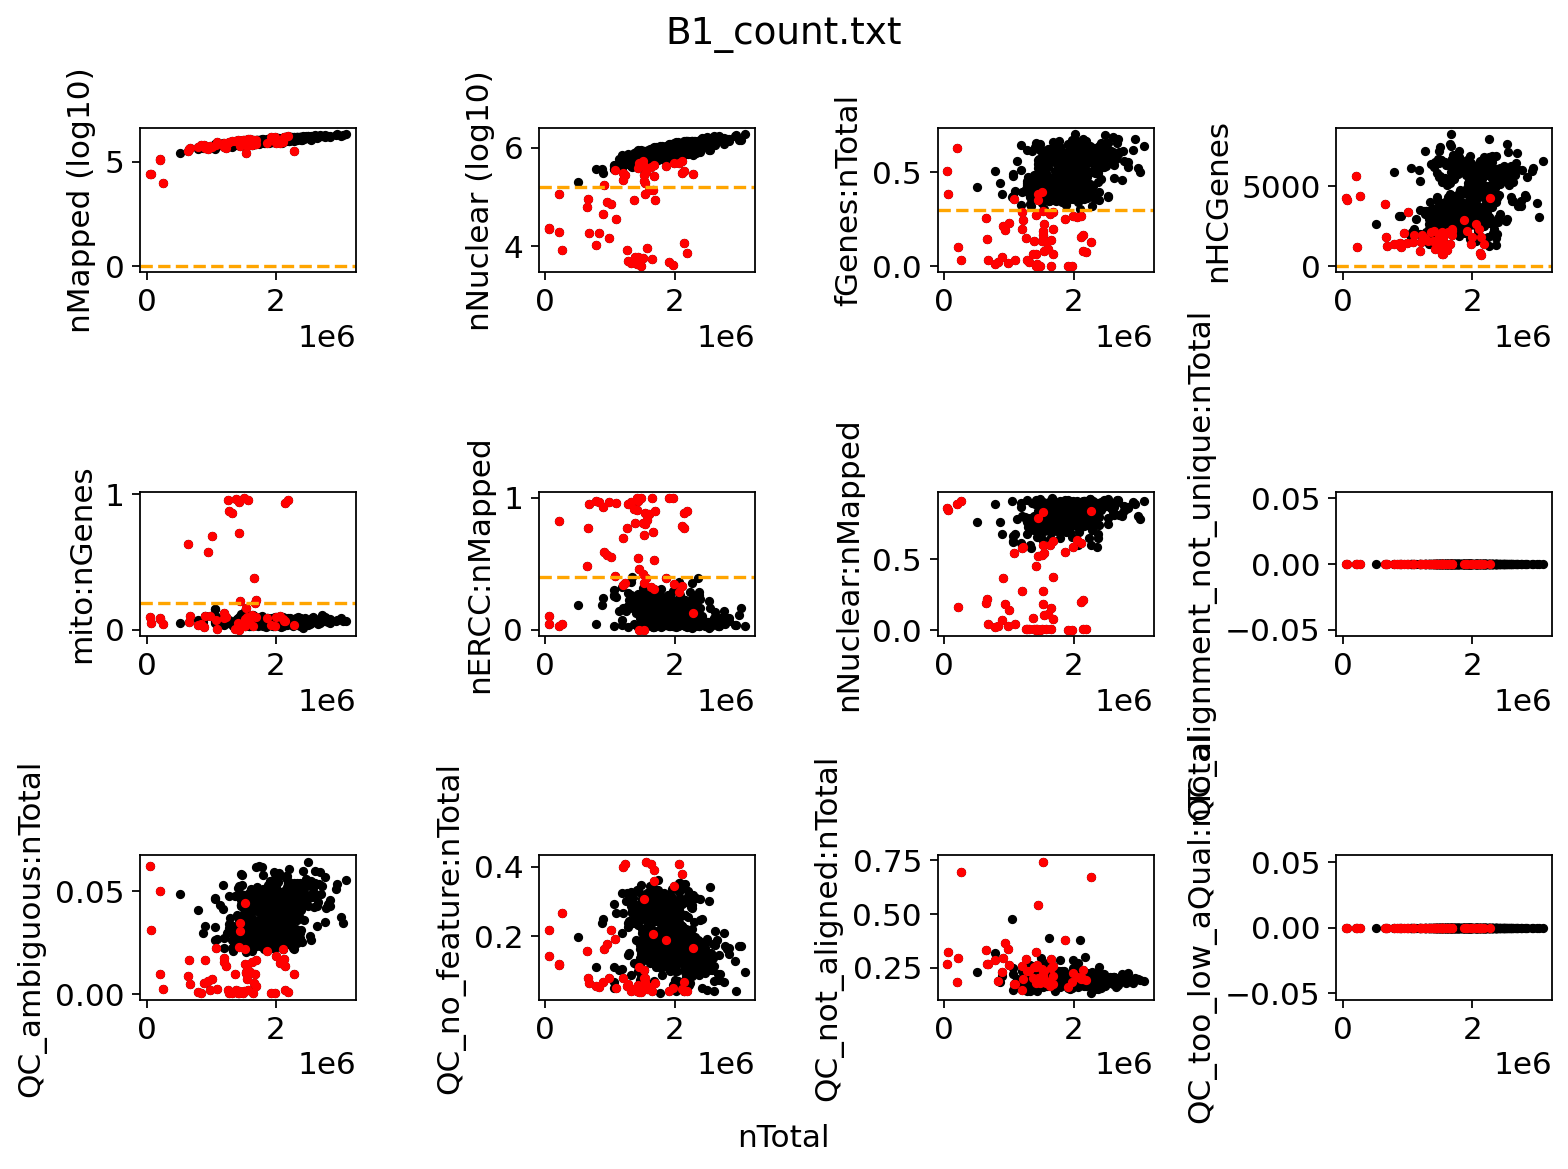

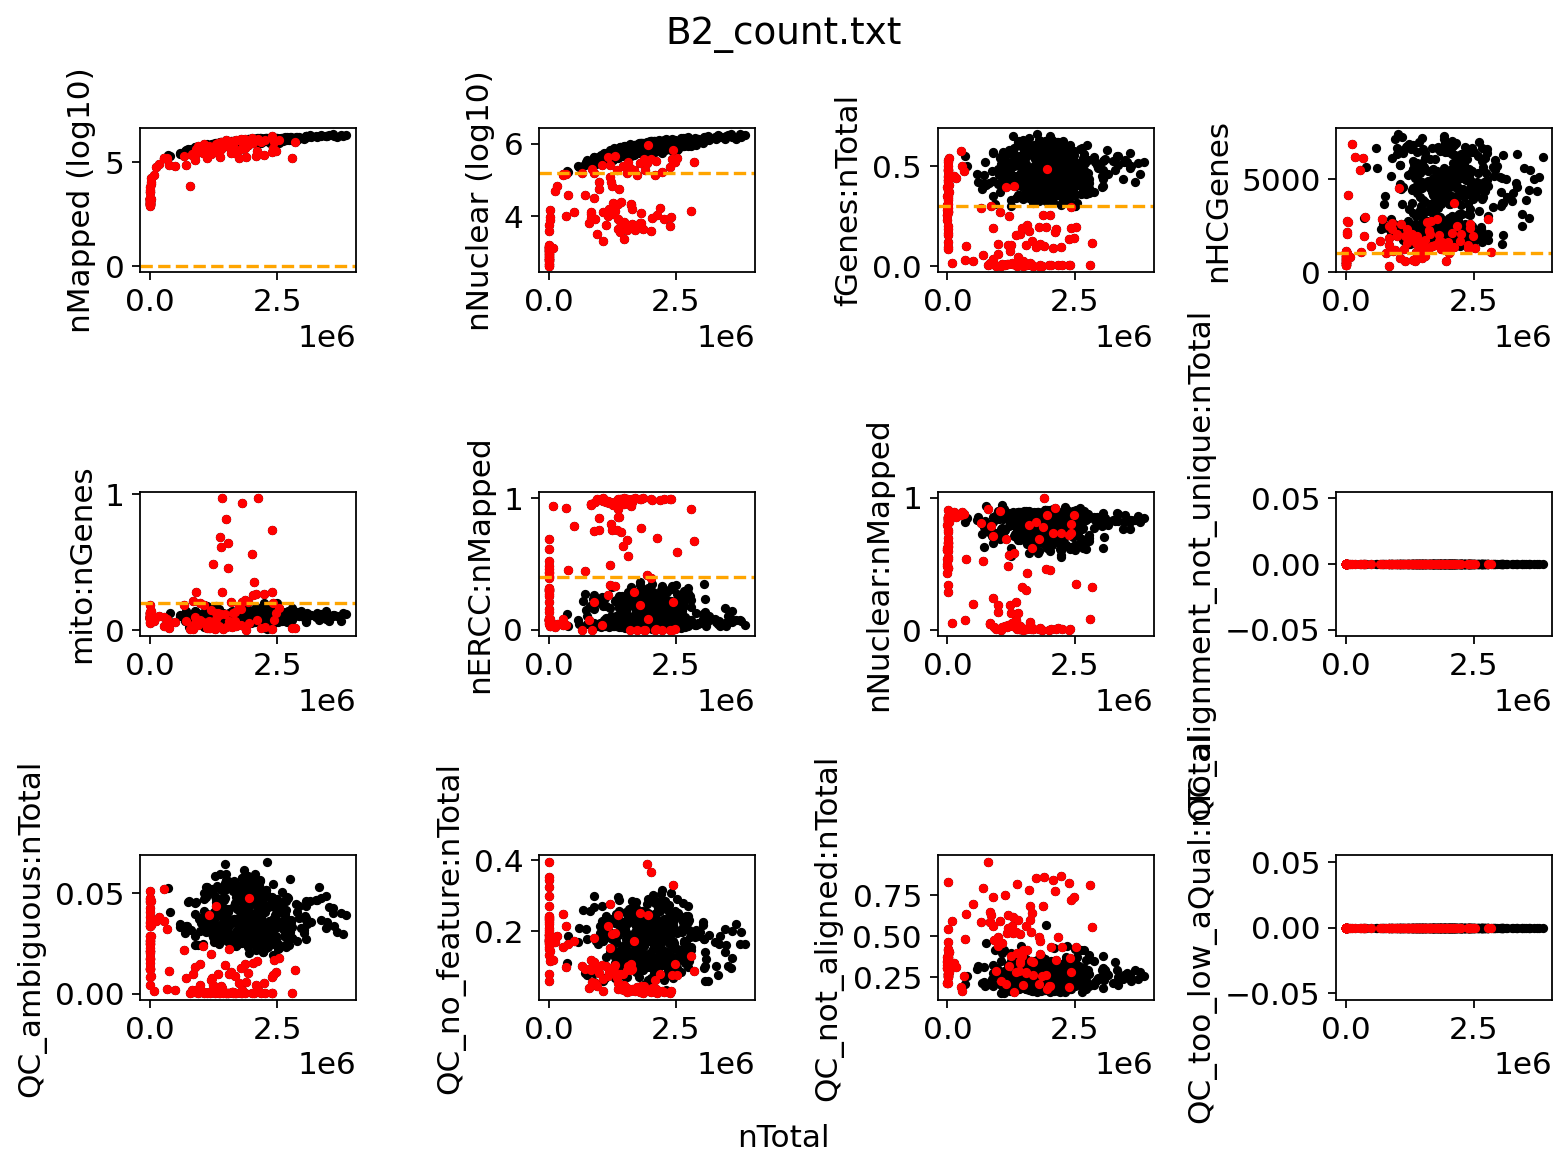

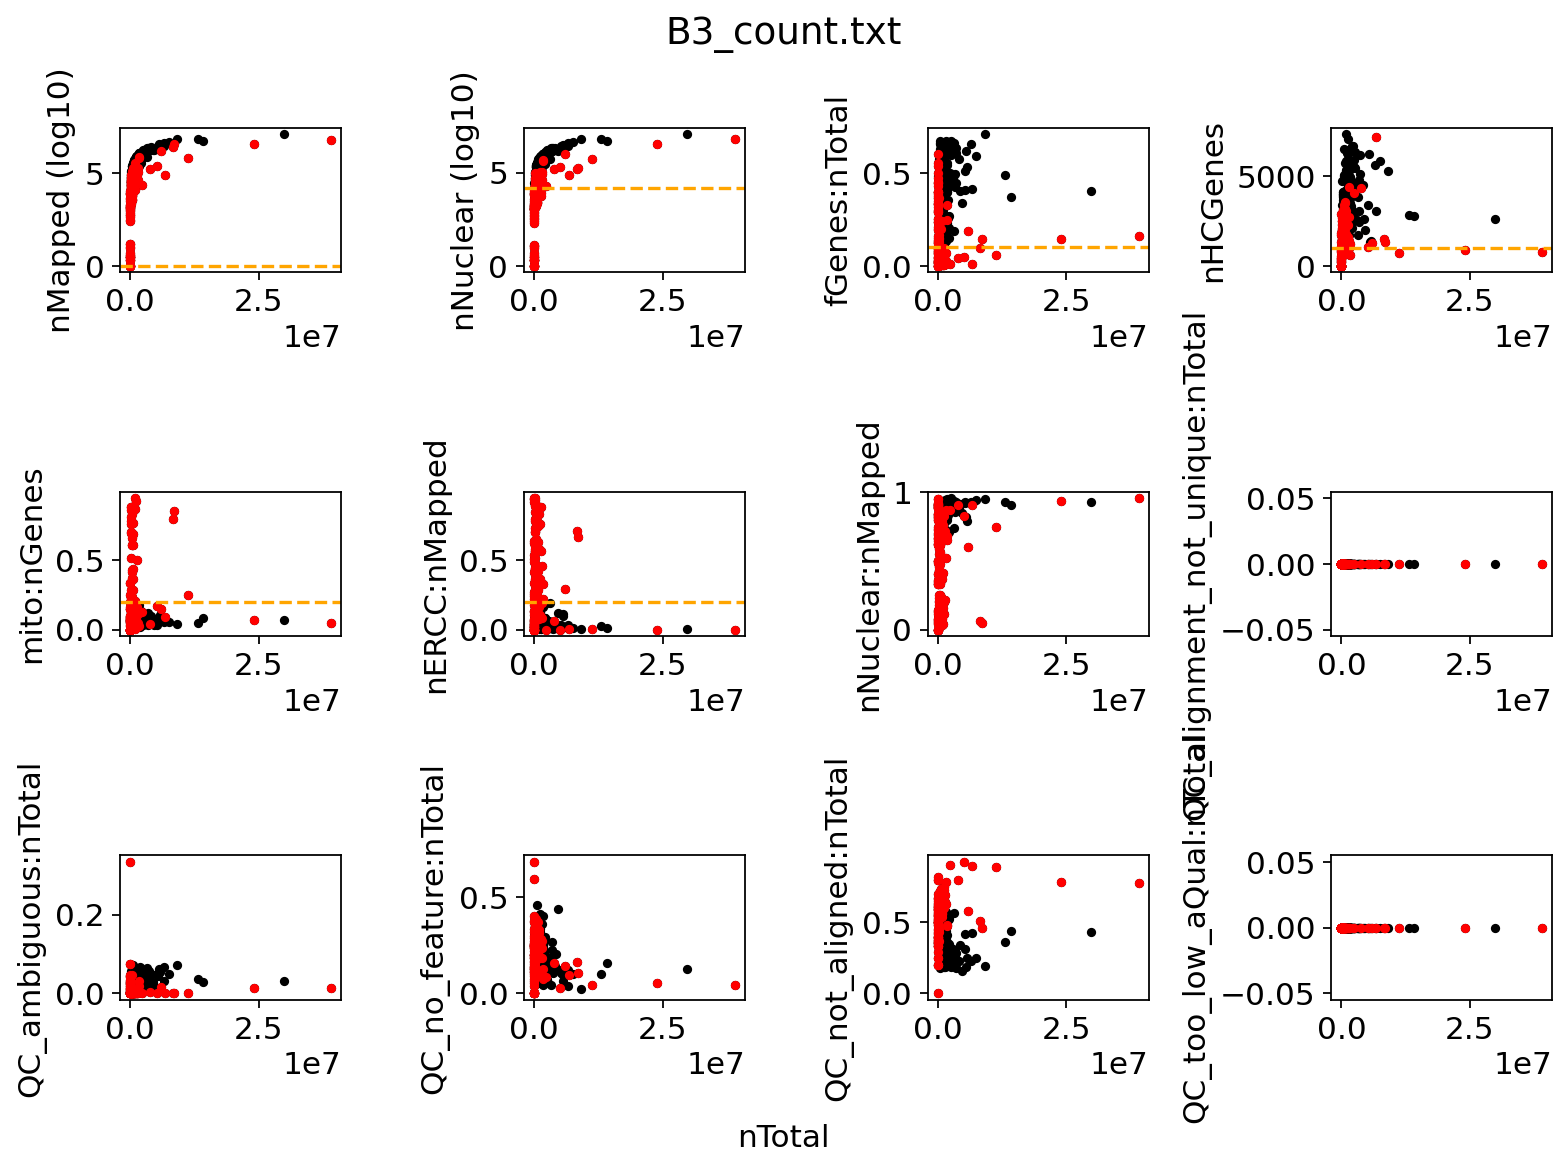

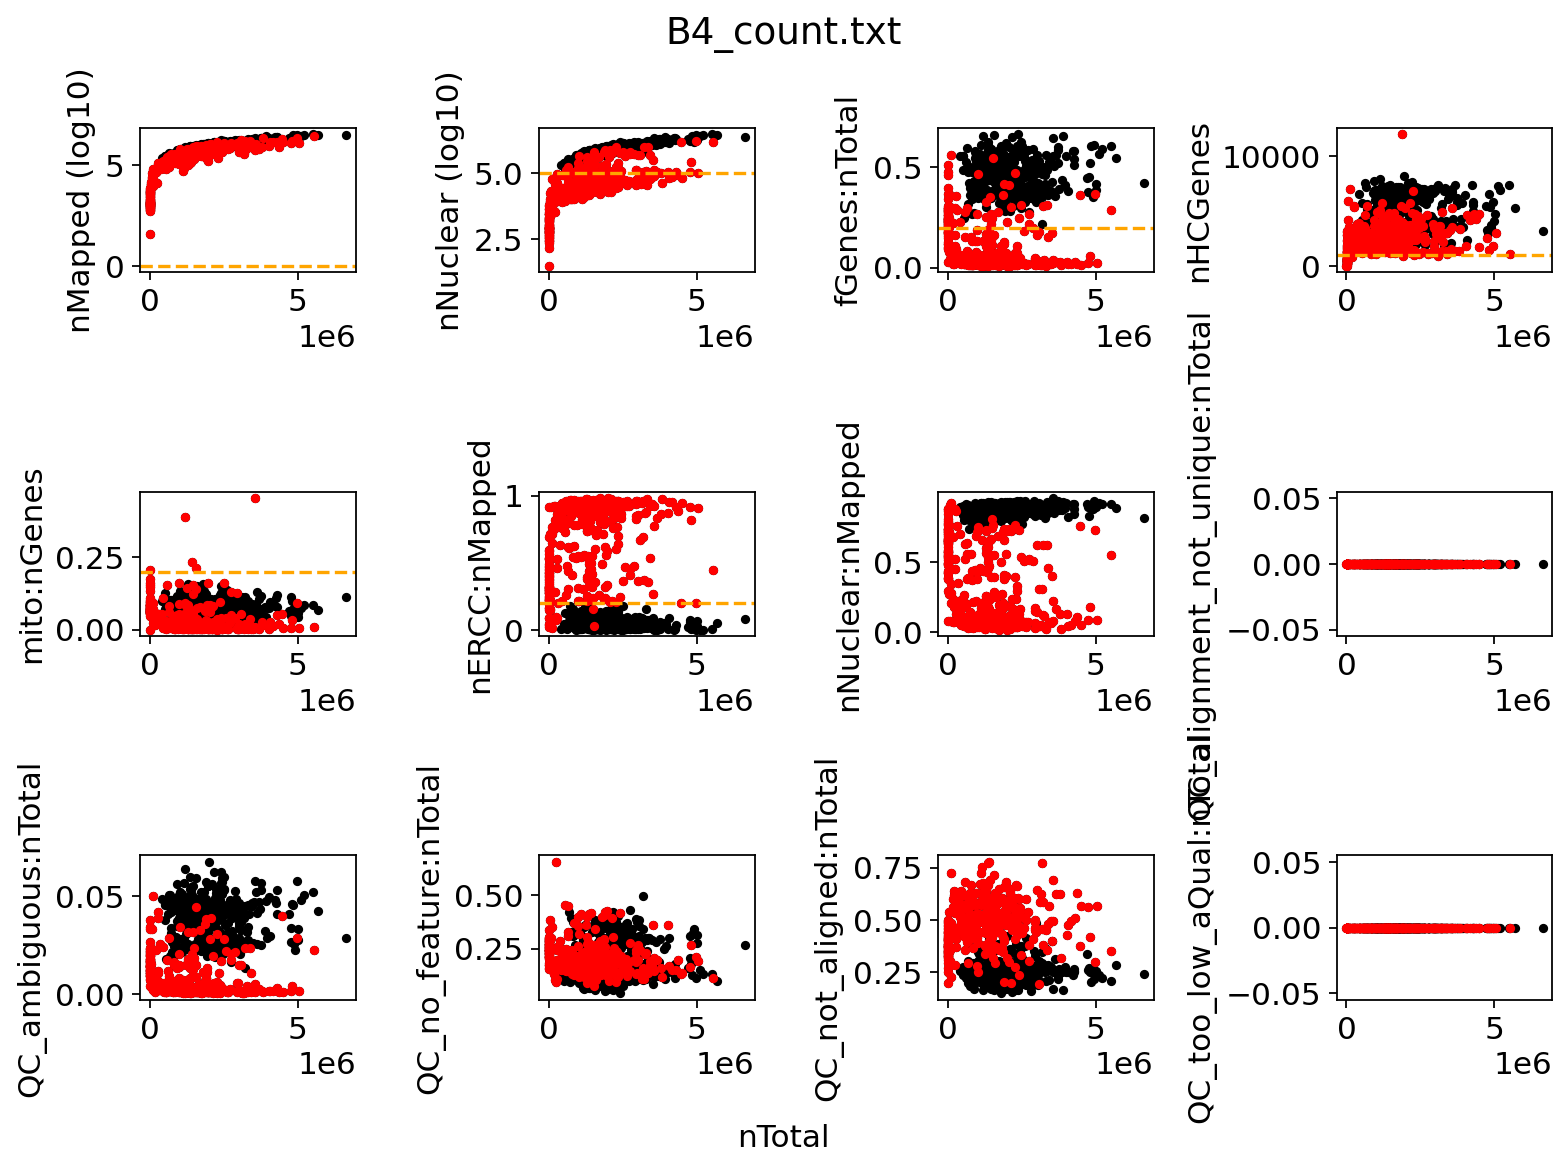

In [6]:
adata = []
for i in range(len(folder_list)):
    print(folder_list[i])
    adata_sub = smqpp.read_in_files(Indir+folder_list[i], ftable_loc, method='HTSeqcount')
    adata_sub.obs['eGFP'] = adata_sub[:,'eGFP'].X.flatten()
    adata_sub = adata_sub[:, adata_sub.var_names != 'eGFP'].copy()
    adata_sub.var_names_make_unique()
    adata_sub = smqpp.smartseq_qc(adata_sub,cutoff=cutoff[i], title=folder_list[i], MTpattern='MT-')
    adata.append(adata_sub)
    del adata_sub

In [7]:
# combine data
adata = anndata.AnnData.concatenate(adata[0], adata[1], adata[2], adata[3])
adata.obs_names = [x[:-2] for x in adata.obs_names]
# add in meta
adata.obs = pd.concat([adata.obs, meta], axis=1, join='inner')

In [9]:
adata

AnnData object with n_obs × n_vars = 1525 × 65988 
    obs: 'QC_alignment_not_unique', 'QC_ambiguous', 'QC_no_feature', 'QC_not_aligned', 'QC_too_low_aQual', 'batch', 'eGFP', 'n_counts', 'n_genes', 'percent_mito', 'Gottgens_ID_RBGxxx', 'CRI_identifier', 'CRI_run', 'Plate_number', 'Position_in_96_well_plate_sorted', 'Position_in_96_well_plate_RNA_seq', 'FACs_index_data', 'Sample_name', 'Details', 'Cell_type_general', 'Cell_type_subtype', 'Expected_cell_number_for_10x_genomics', 'Owner', 'Species', 'CI_annotation_of_index', 'Index_name_in_library_Set', 'Average_Library_Length_bp', 'Average_pooled_library_length_bp', 'Pool_size', 'Number_of_lanes', 'Number_of_additional_lanes_ordered_i_e_repeats', 'Paid_Y_N', 'Invoice_number', 'Price', 'Cell_Type', 'Day', 'Condition', 'Plate', 'Batch', 'ID'
    var: 'Gene Name', 'Gene Type', 'Ensembl_ID'
    obsm: 'ERCC'

In [17]:
# Here are the outlier cells either empty or behave weiredly, 15 in total
# 1st list: the cells that are supposed to be empty
outlier1 = adata.obs_names[adata.obs['Condition'] == 'Empty'].values
# 2nd list: the cells that effect HVG selection
outlier2 = np.array(["SLX.12981.i705_i503", "SLX.17052.i706_i506","SLX.17052.i721_i518", "SLX.17052.i729_i518", "SLX.17053.i727_i515"])
# 3nd list: the Day0 cells are clustered into Day3 cells
outlier3 = np.genfromtxt('exCells_in_wrong_cluster.txt', delimiter='\t', dtype=str)
outliers = np.concatenate([outlier1, outlier2, outlier3])
print(len(outliers))

15


In [18]:
adata = adata[~np.in1d(adata.obs_names, outliers),:].copy()

In [19]:
adata

AnnData object with n_obs × n_vars = 1512 × 65988 
    obs: 'QC_alignment_not_unique', 'QC_ambiguous', 'QC_no_feature', 'QC_not_aligned', 'QC_too_low_aQual', 'batch', 'eGFP', 'n_counts', 'n_genes', 'percent_mito', 'Gottgens_ID_RBGxxx', 'CRI_identifier', 'CRI_run', 'Plate_number', 'Position_in_96_well_plate_sorted', 'Position_in_96_well_plate_RNA_seq', 'FACs_index_data', 'Sample_name', 'Details', 'Cell_type_general', 'Cell_type_subtype', 'Expected_cell_number_for_10x_genomics', 'Owner', 'Species', 'CI_annotation_of_index', 'Index_name_in_library_Set', 'Average_Library_Length_bp', 'Average_pooled_library_length_bp', 'Pool_size', 'Number_of_lanes', 'Number_of_additional_lanes_ordered_i_e_repeats', 'Paid_Y_N', 'Invoice_number', 'Price', 'Cell_Type', 'Day', 'Condition', 'Plate', 'Batch', 'ID'
    var: 'Gene Name', 'Gene Type', 'Ensembl_ID'
    obsm: 'ERCC'

In [20]:
adata.write('./write/MPB1234_raw.h5ad')

... storing 'CRI_identifier' as categorical
... storing 'CRI_run' as categorical
... storing 'Plate_number' as categorical
... storing 'Position_in_96_well_plate_sorted' as categorical
... storing 'Position_in_96_well_plate_RNA_seq' as categorical
... storing 'FACs_index_data' as categorical
... storing 'Sample_name' as categorical
... storing 'Details' as categorical
... storing 'Cell_type_general' as categorical
... storing 'Cell_type_subtype' as categorical
... storing 'Owner' as categorical
... storing 'Species' as categorical
... storing 'CI_annotation_of_index' as categorical
... storing 'Index_name_in_library_Set' as categorical
... storing 'Cell_Type' as categorical
... storing 'Day' as categorical
... storing 'Condition' as categorical
... storing 'Plate' as categorical
... storing 'Batch' as categorical
... storing 'Gene Name' as categorical
... storing 'Gene Type' as categorical


# Normalisation

In [21]:
adata =sc.read('./write/MPB1234_raw.h5ad')

In [22]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 16663 genes that are detected in less than 1 cells


In [23]:
smqpp.normalise_data(adata)

Calculate SF for genes:
Filtered matrix shape: (1512, 23)
Number of valid means:23
Calculate SF for erccs:
Filtered matrix shape: (1512, 8)
Number of valid means:8


In [24]:
adata.raw = adata

In [25]:
adata.write('./write/MPB1234_lognorm_afterQC_new.h5ad')

# Check for Cell Cycle

In [26]:
adata = sc.read('./write/MPB1234_lognorm_afterQC_new.h5ad')
adata.var_names_make_unique()

In [27]:
sc.pp.scale(adata)

In [28]:
cell_cycle_genes = [x.strip() for x in open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/regev_lab_cell_cycle_genes.txt')]

In [29]:
print(len(cell_cycle_genes))

97


In [30]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = np.intersect1d(cell_cycle_genes, adata.var_names)
print(len(s_genes))
print(len(g2m_genes))
print(len(cell_cycle_genes))

43
54
96


In [31]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [32]:
adata.obs['phase'].value_counts()

G1     803
S      505
G2M    204
Name: phase, dtype: int64

In [33]:
# save cell cycle results
np.savetxt('phase.txt', adata.obs['phase'], delimiter='\t', fmt='%s')
np.savetxt('S_score.txt', adata.obs['S_score'], delimiter='\t')
np.savetxt('G2M_score.txt', adata.obs['G2M_score'], delimiter='\t')

# Check for GFP

In [34]:
adata = sc.read('./write/MPB1234_lognorm_afterQC_new.h5ad')
adata.var_names_make_unique()

In [35]:
adata.obs['con_comb'] = adata.obs['Day'].astype(str)+'_'+adata.obs['Cell_Type'].astype(str)+'_'+adata.obs['Condition'].astype(str)
adata.obs['con_comb'].value_counts().sort_index()

Day0_CD34+_NT          209
Day0_LT-HSC_NT         218
Day0_ST-HSC_NT         171
Day3_CD34+_GFP+PD-     112
Day3_CD34+_GFP-PD-      90
Day3_CD34+_NT           97
Day3_LT-HSC_GFP+PD+     57
Day3_LT-HSC_GFP+PD-    143
Day3_LT-HSC_GFP-PD+     37
Day3_LT-HSC_GFP-PD-     80
Day3_LT-HSC_NT          75
Day3_ST-HSC_GFP+PD-     94
Day3_ST-HSC_GFP-PD-     58
Day3_ST-HSC_NT          71
Name: con_comb, dtype: int64

In [36]:
adata.obs['eGFP_norm'] = np.log1p(adata.obs['eGFP']/adata.obs['sf_gene'])

In [37]:
df_temp = adata.obs[['con_comb','eGFP', 'eGFP_norm', 'Day', 'Cell_Type', 'Condition']]

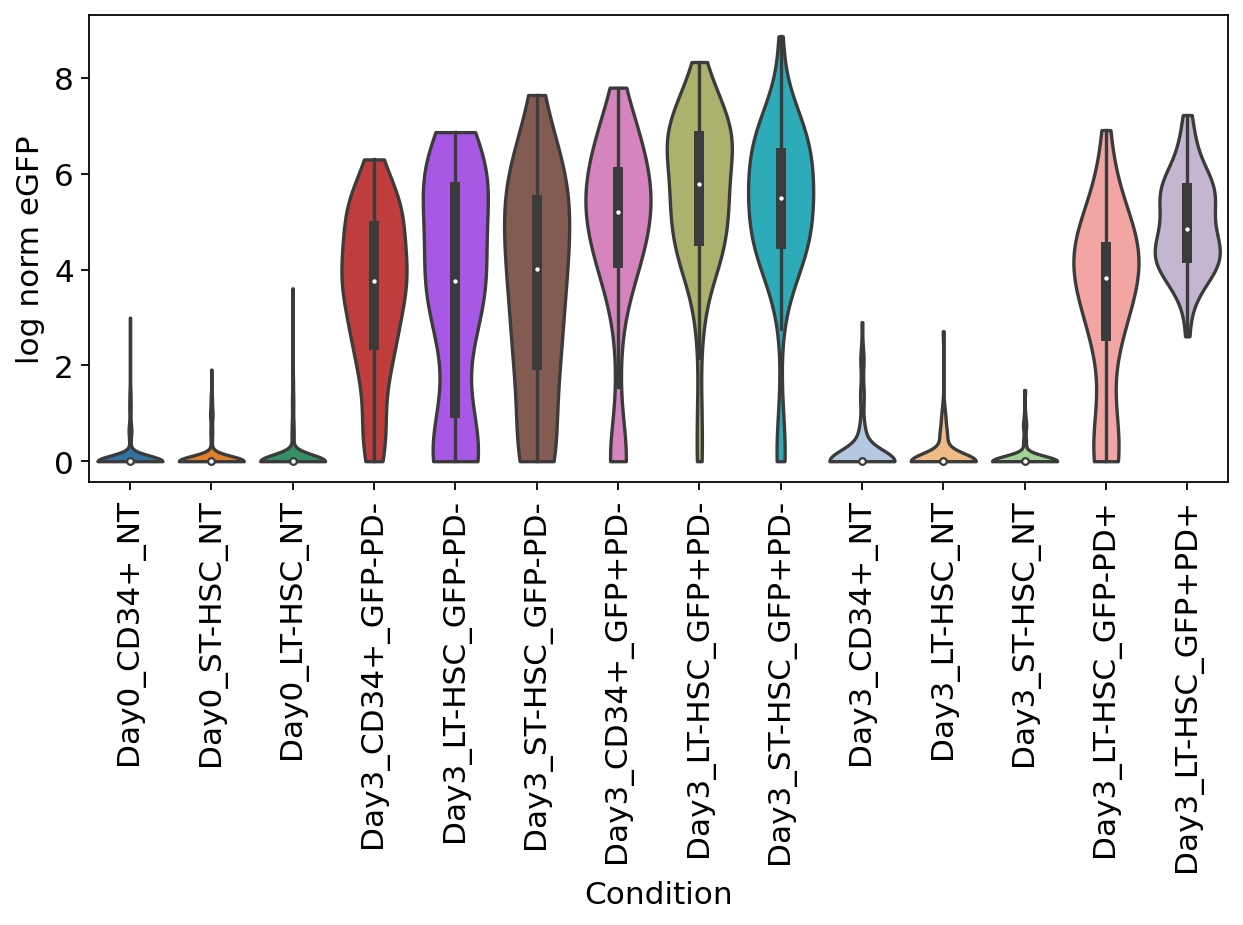

In [68]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.violinplot(x='con_comb', y='eGFP_norm', data=df_temp, cut=0, scale='width')
ax.grid(False)
ax.set_xlabel('Condition')
ax.set_ylabel('log norm eGFP')
plt.xticks(rotation='90')
plt.tight_layout()
plt.savefig('./figures/Violinplot_GFP_norm.pdf')

In [39]:
tab1 = pd.crosstab( df_temp['con_comb'] ,df_temp['eGFP_norm'] >0, normalize=0)*100
tab1.columns = ['GFP=0', 'GFP>0']
tab1.to_csv('Table_concombvsGFP_norm.csv')

In [40]:
tab1

GFP=0       GFP>0
con_comb                                  
Day0_CD34+_NT        89.952153   10.047847
Day0_LT-HSC_NT       90.825688    9.174312
Day0_ST-HSC_NT       89.473684   10.526316
Day3_CD34+_GFP+PD-   10.714286   89.285714
Day3_CD34+_GFP-PD-    3.333333   96.666667
Day3_CD34+_NT        81.443299   18.556701
Day3_LT-HSC_GFP+PD+   0.000000  100.000000
Day3_LT-HSC_GFP+PD-   2.097902   97.902098
Day3_LT-HSC_GFP-PD+  10.810811   89.189189
Day3_LT-HSC_GFP-PD-  21.250000   78.750000
Day3_LT-HSC_NT       82.666667   17.333333
Day3_ST-HSC_GFP+PD-   4.255319   95.744681
Day3_ST-HSC_GFP-PD-  12.068966   87.931034
Day3_ST-HSC_NT       88.732394   11.267606

In [41]:
adata.write('./write/MPB1234_lognorm_afterQC_new.h5ad')

... storing 'con_comb' as categorical


# Subset HVGs

In [42]:
adata = sc.read('./write/MPB1234_lognorm_afterQC_new.h5ad')

In [43]:
adata.obs['phase'] = np.genfromtxt('phase.txt', delimiter='\t', dtype=str)
adata.obs['S_score'] = np.genfromtxt('S_score.txt', delimiter='\t')
adata.obs['G2M_score'] = np.genfromtxt('G2M_score.txt', delimiter='\t')

In [44]:
smqpp.tech_var(adata, useERCC=True, meanForFit=10) 

MeanForFit:  10
43
Length of HVGs: 1599


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


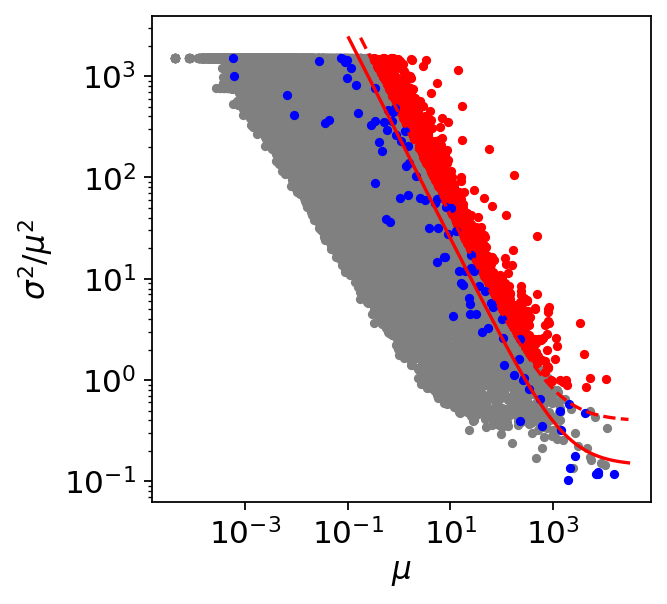

In [45]:
smqpp.plot_tech_var(adata)

In [46]:
adata.shape

(1512, 49325)

In [47]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [48]:
adata.shape

(1512, 1599)

In [49]:
# scale for pca
sc.pp.scale(adata)

In [50]:
adata.obs['Batch'].value_counts().sort_index()

B1    493
B2    436
B3    209
B4    374
Name: Batch, dtype: int64

# Visualisation

In [51]:
sc.tl.pca(adata,svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:00)


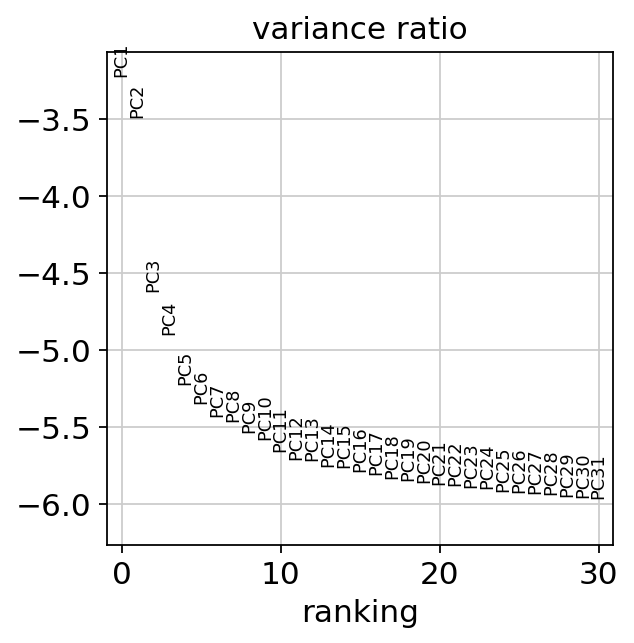

In [52]:
sc.pl.pca_variance_ratio(adata, log=True)

In [53]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)


In [55]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


In [56]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:09)


In [57]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:06)


In [58]:
adata.write('./write/MPB1234_processed_new.h5ad')

... storing 'phase' as categorical


## Plot them out

In [59]:
adata = sc.read('./write/MPB1234_processed_new.h5ad')

In [60]:
# Carys would like to change Day variable
adata.obs['Day'] = adata.obs['Day'].astype('category')
adata.obs['Day'] = adata.obs['Day'].cat.rename_categories(['0hr', '62hr'])

In [61]:
main_keys = ['Day', 'Cell_Type', 'Condition', 'Plate', 'Batch',
            'n_counts', 'n_genes', 'eGFP_norm', 'phase']

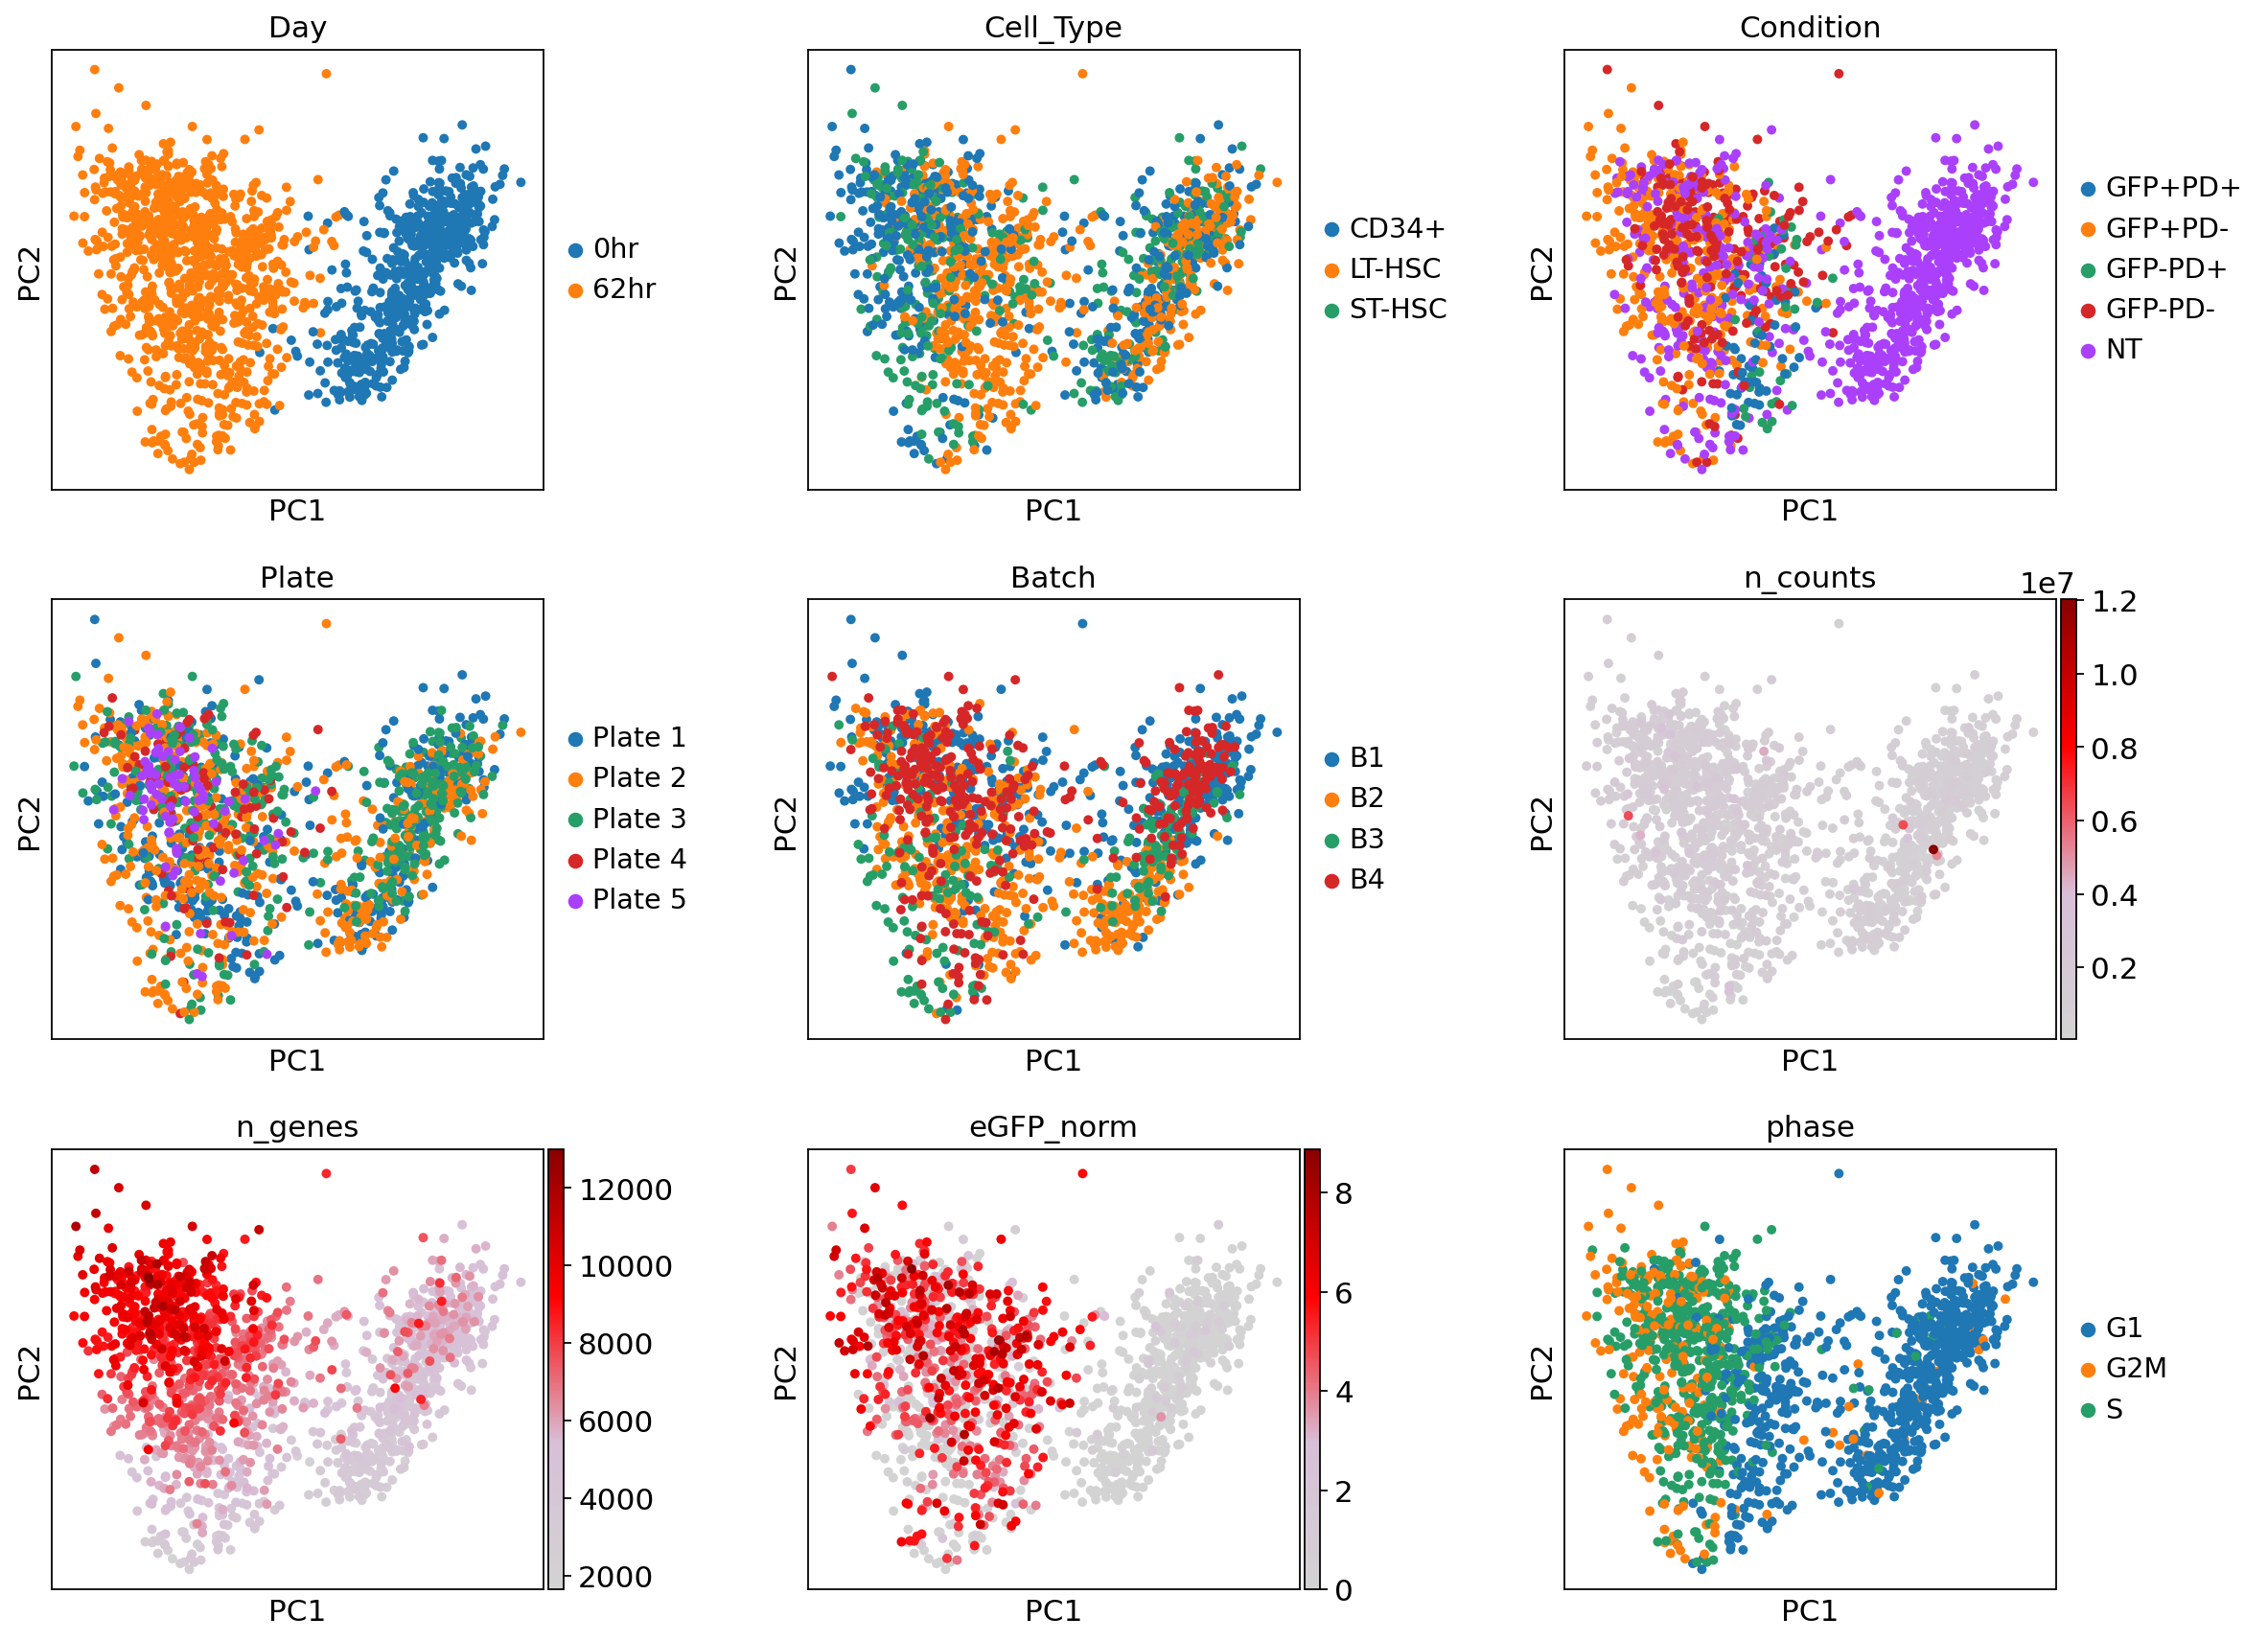

In [62]:
sc.pl.pca_scatter(adata, color=main_keys, wspace=0.4, ncols=3, color_map=cmap, save='_MPB1234.pdf')

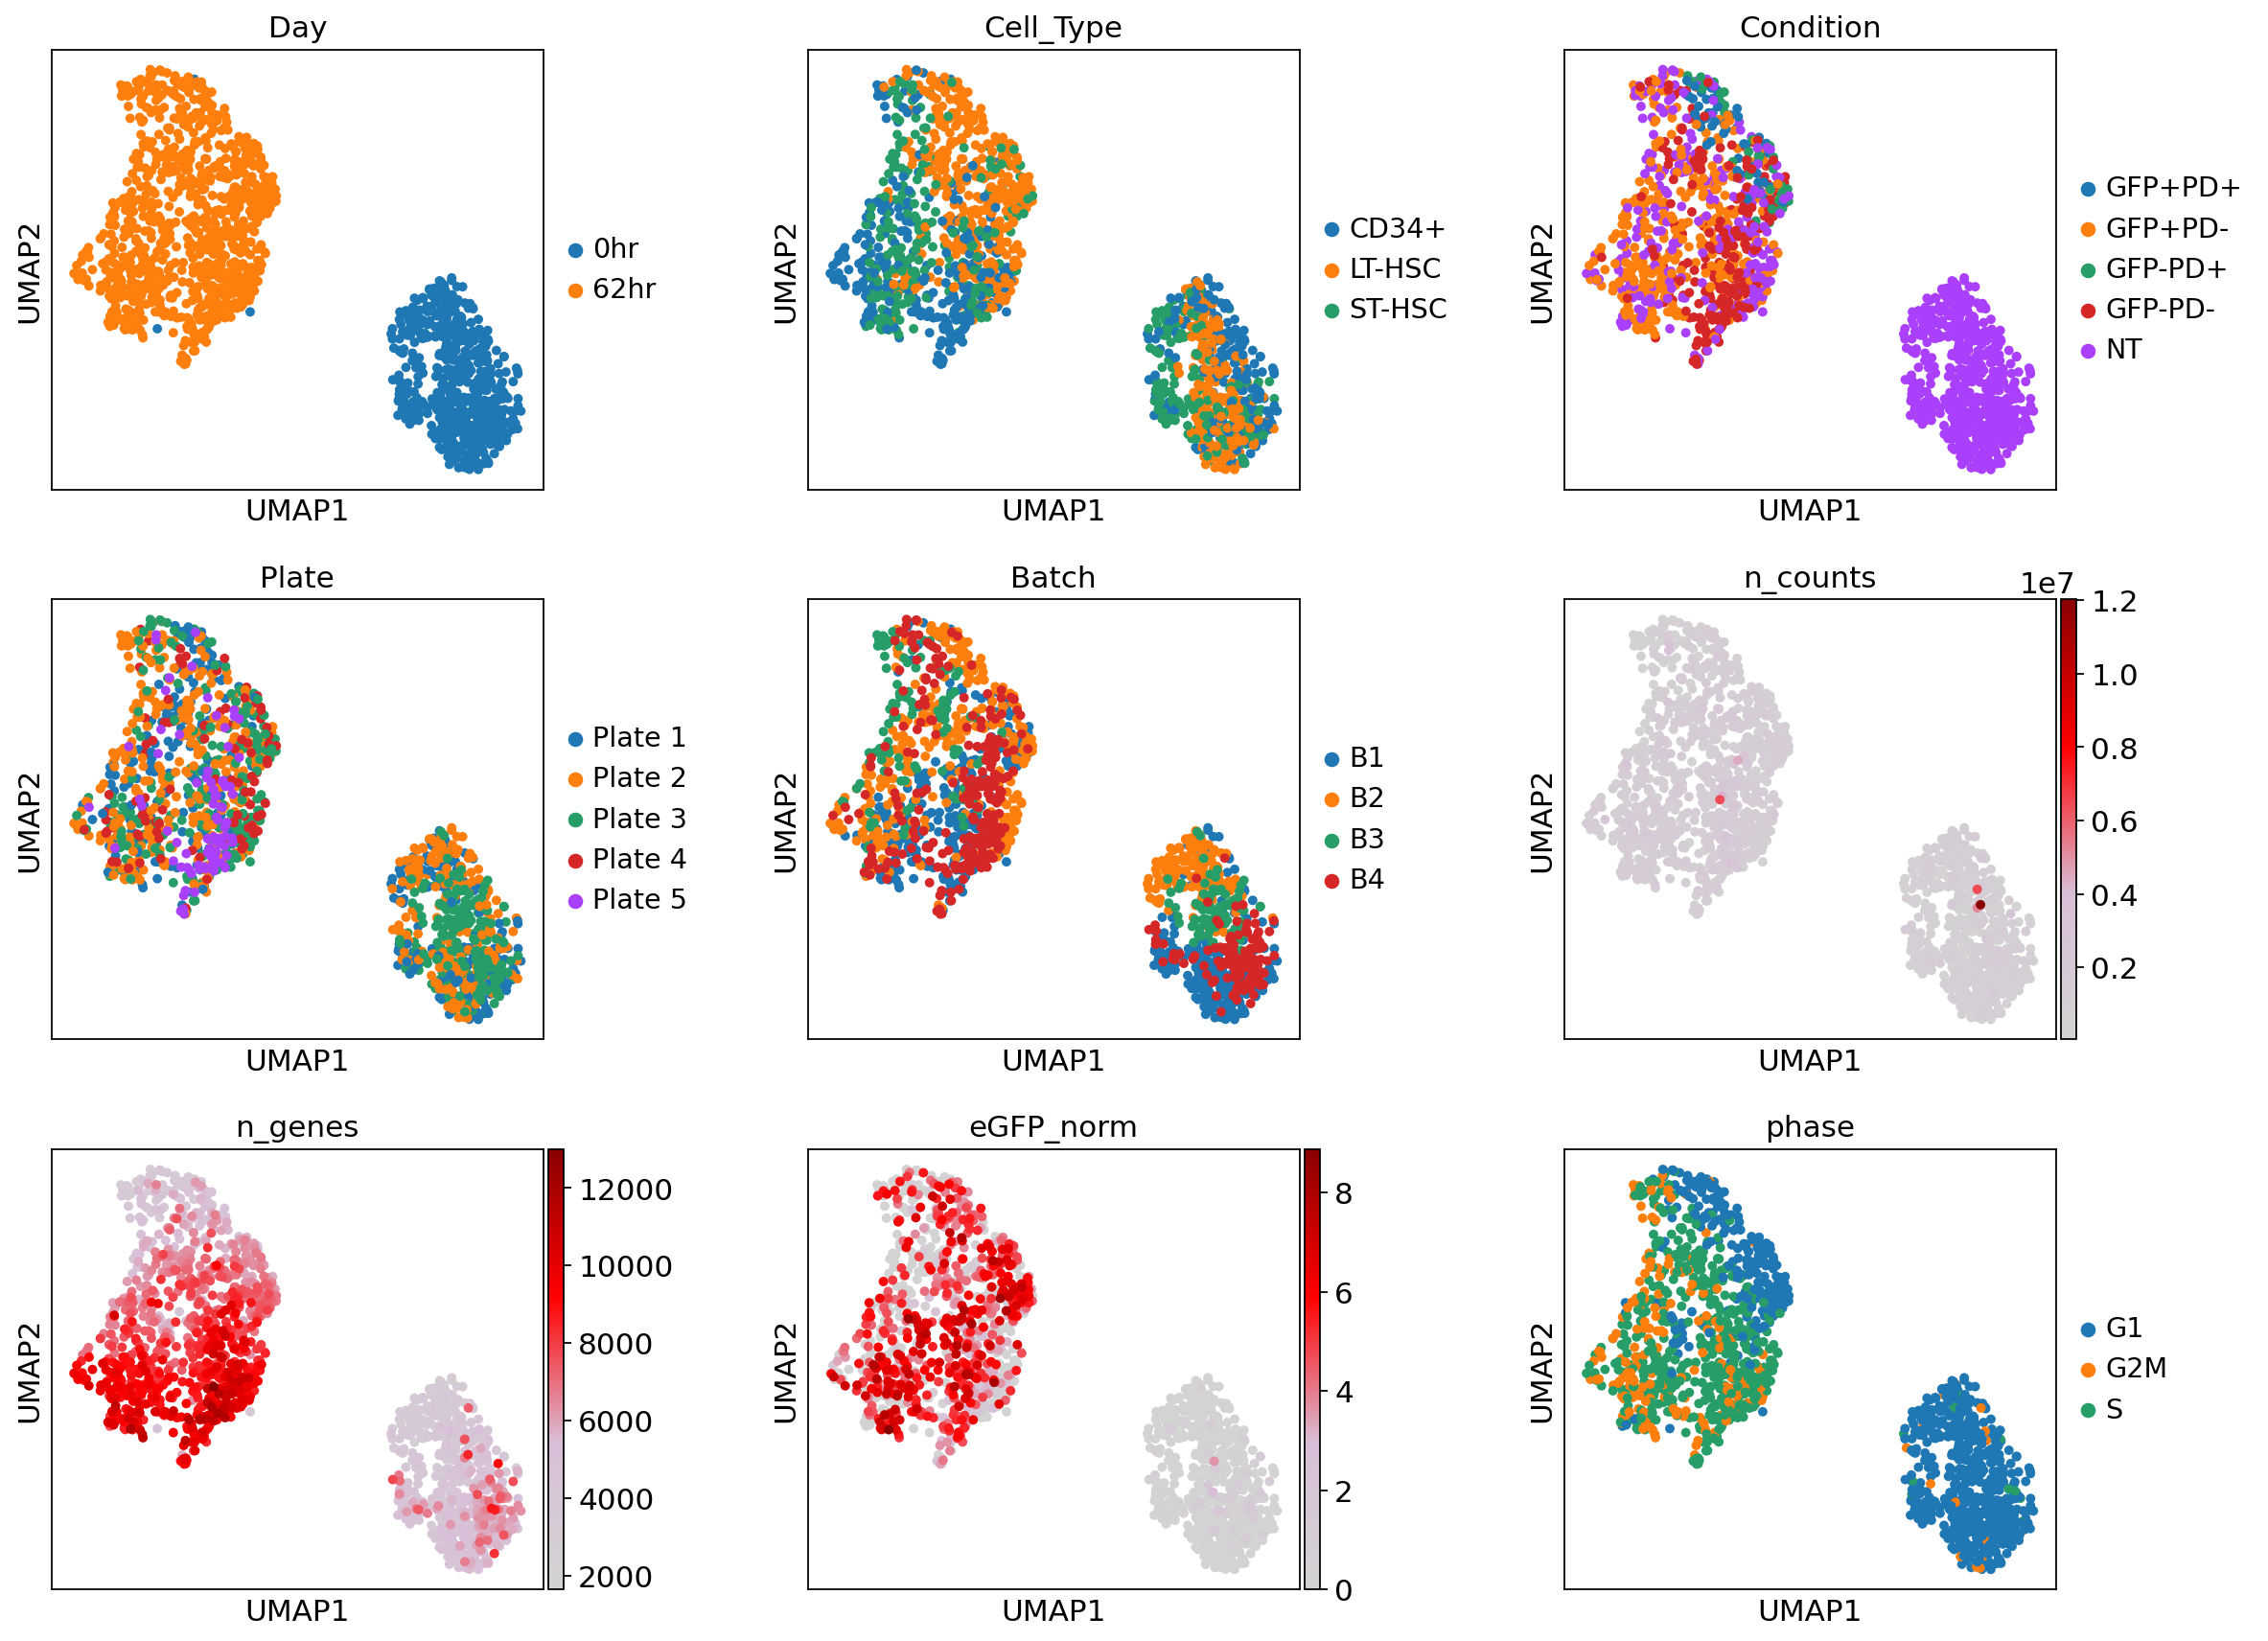

In [63]:
sc.pl.umap(adata, color=main_keys, wspace=0.4, ncols=3, color_map=cmap, save='_MPB1234.pdf')

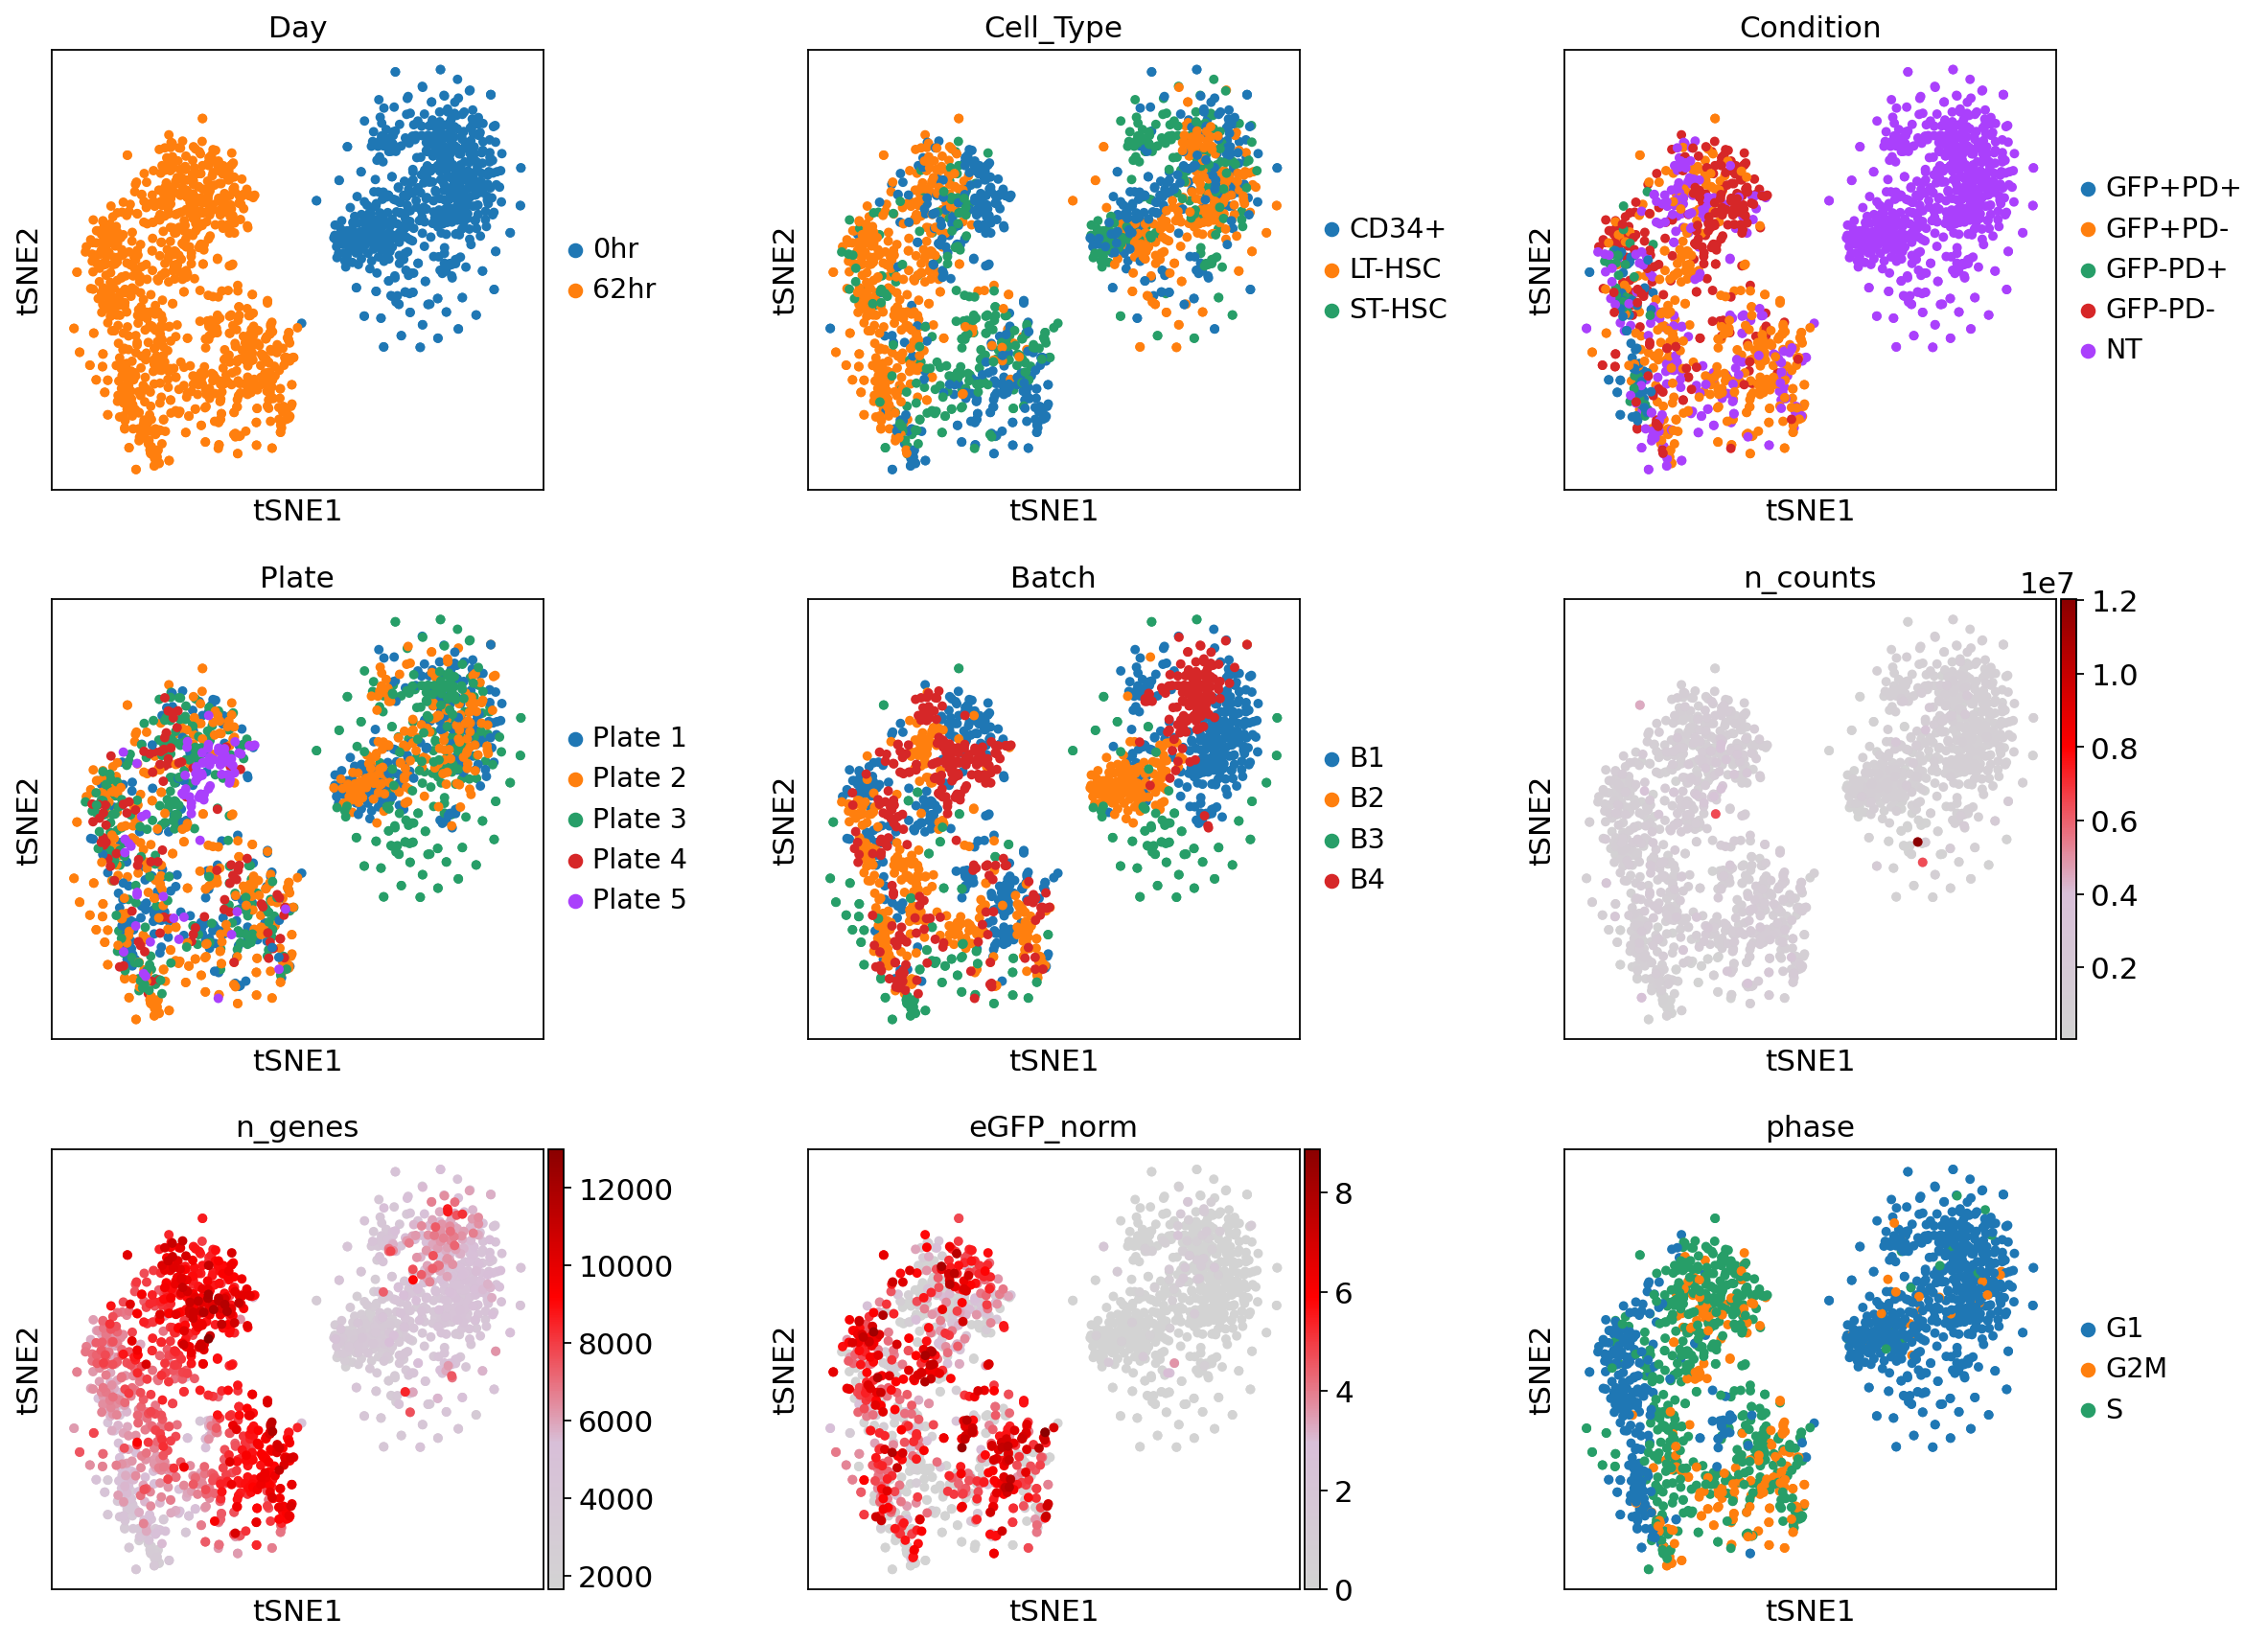

In [64]:
sc.pl.tsne(adata, color=main_keys, wspace=0.4, ncols=3, color_map=cmap, save='_MPB1234.pdf')

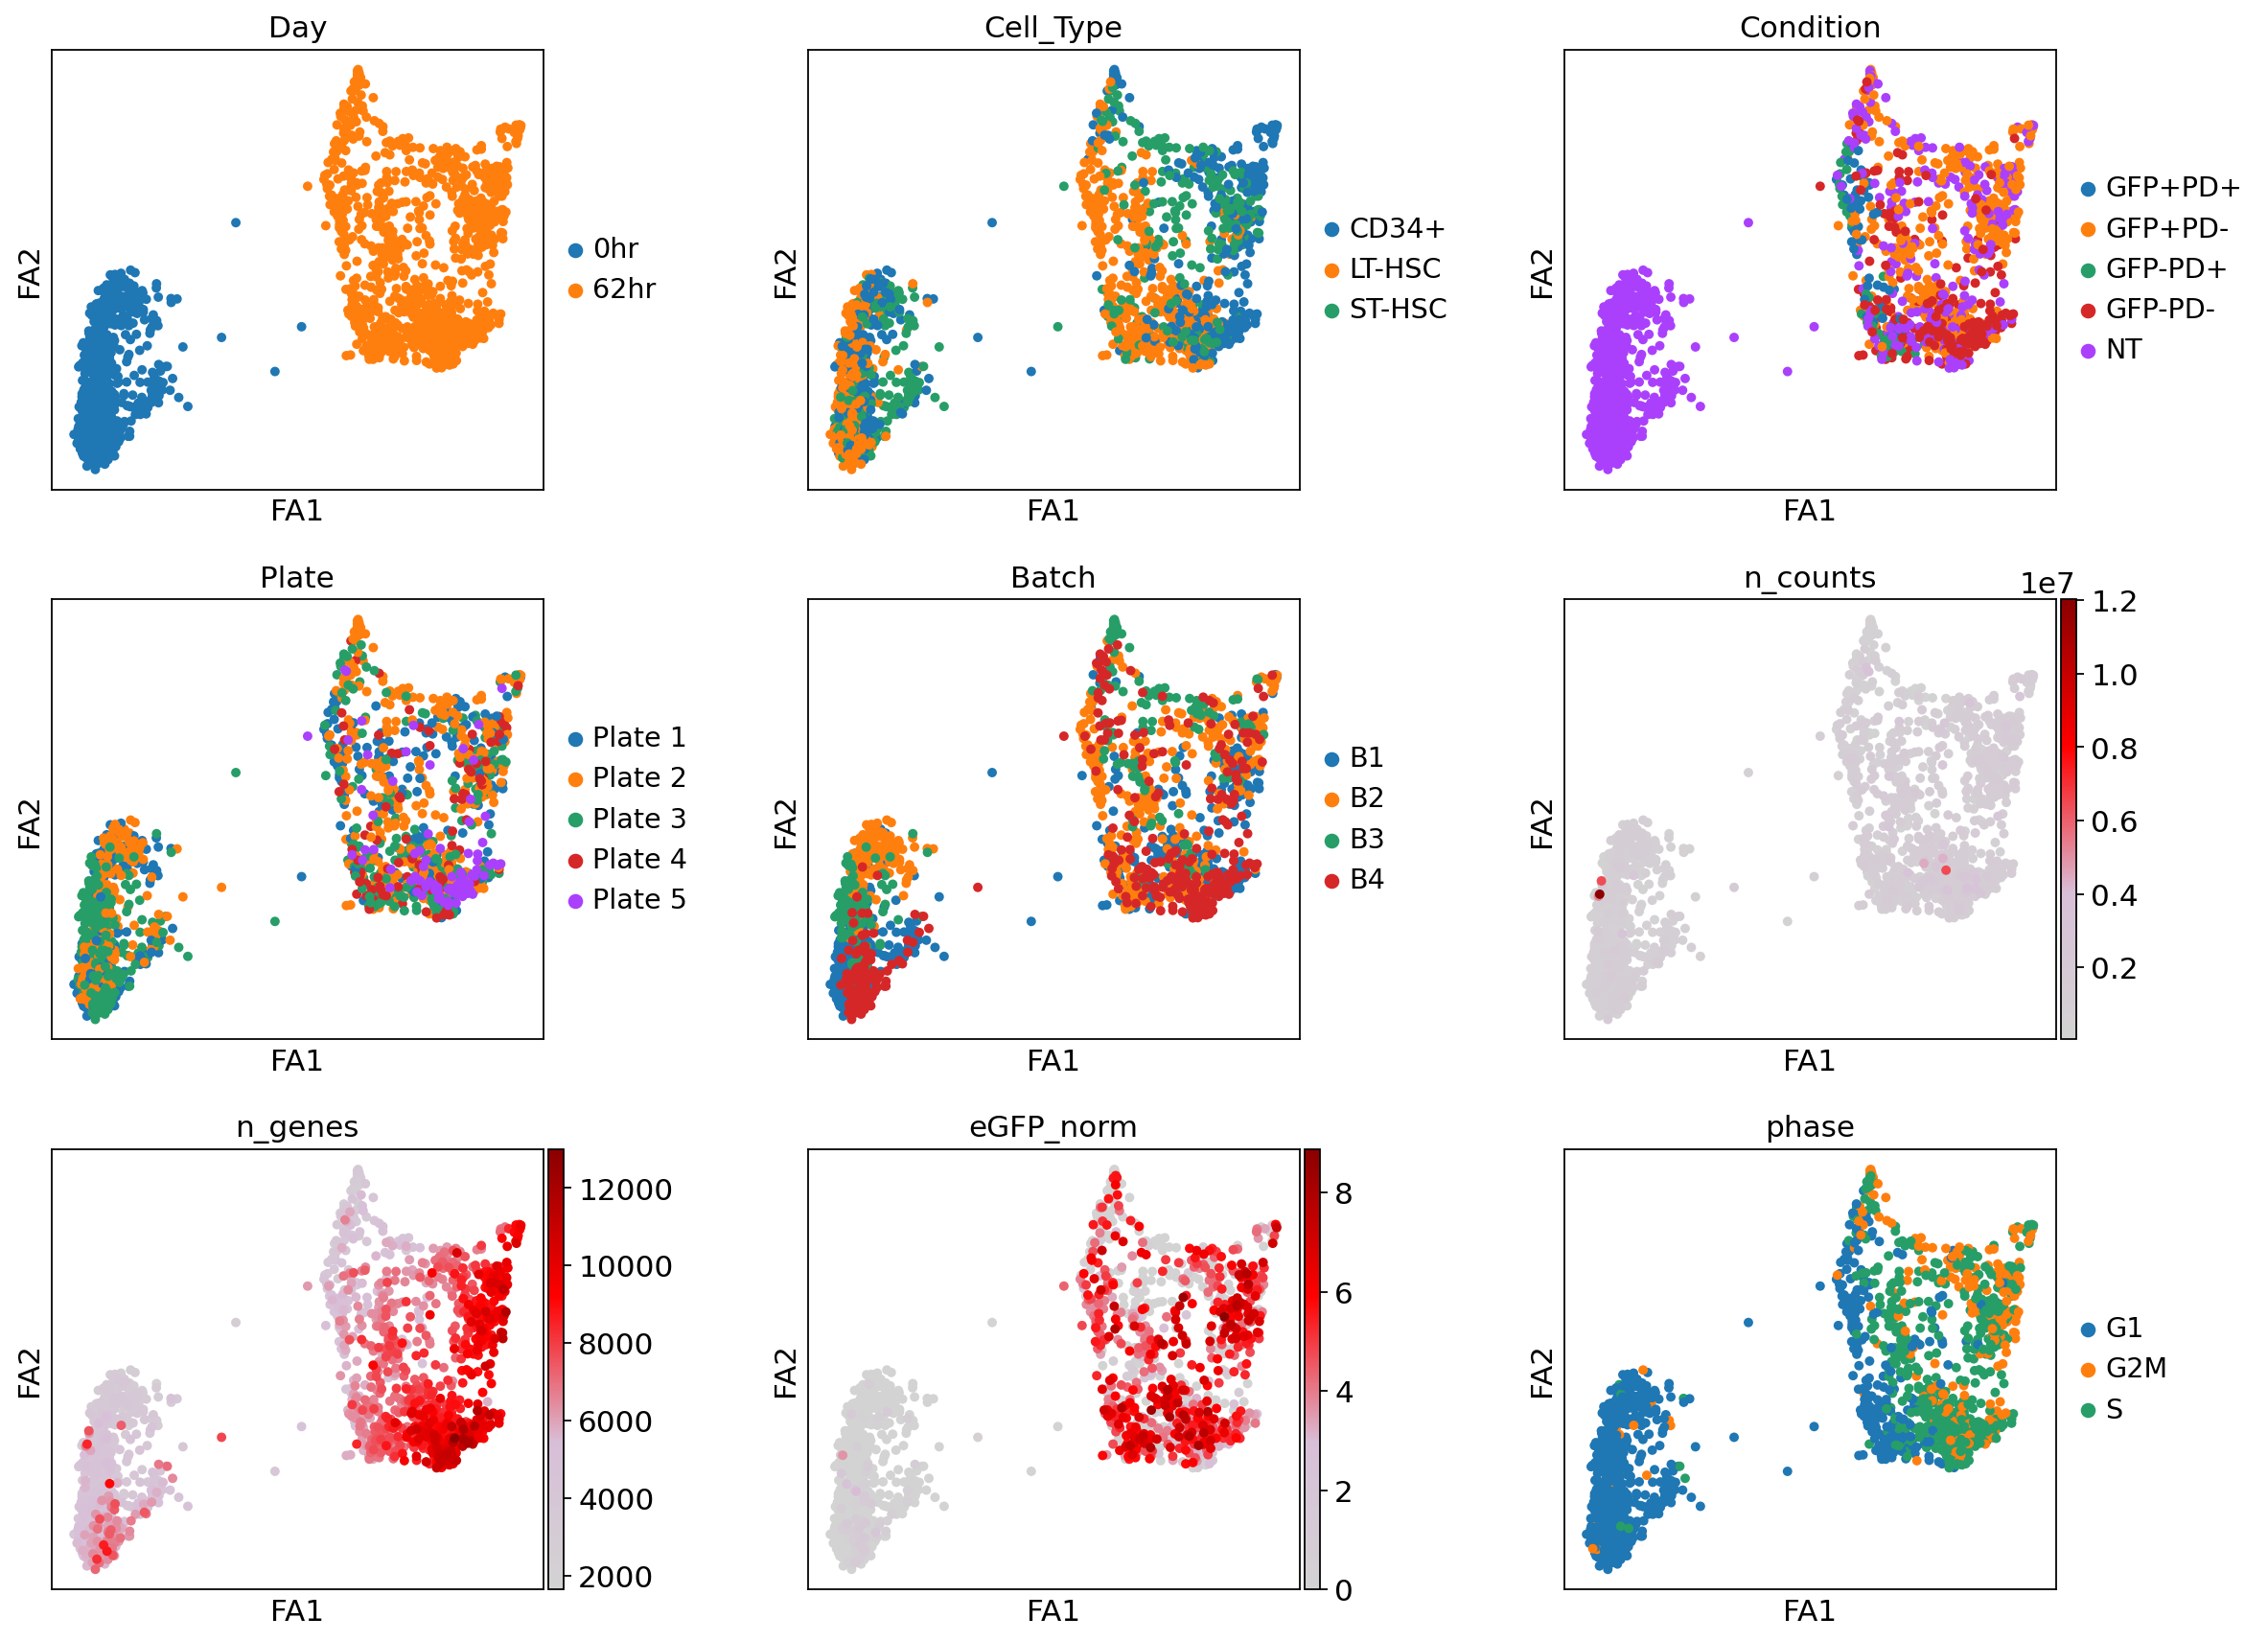

In [65]:
sc.pl.draw_graph(adata, color=main_keys, wspace=0.4, ncols=3, color_map=cmap, save='_MPB1234.pdf')

In [66]:
adata.write('./write/MPB1234_processed_new.h5ad')

# Split data

In [69]:
adata = sc.read('./write/MPB1234_processed_new.h5ad')
adata_raw = sc.read('./write/MPB1234_raw.h5ad')
adata_raw.obs = adata.obs
adata_day0 = adata_raw[adata_raw.obs['Day'] == '0hr', :].copy()
adata_day3 = adata_raw[adata_raw.obs['Day'] == '62hr', :].copy()
adata_day0.write('./write/MPB1234_raw_Day0.h5ad')
adata_day3.write('./write/MPB1234_raw_Day3.h5ad')

In [70]:
adata_day0

AnnData object with n_obs × n_vars = 598 × 65988 
    obs: 'QC_alignment_not_unique', 'QC_ambiguous', 'QC_no_feature', 'QC_not_aligned', 'QC_too_low_aQual', 'batch', 'eGFP', 'n_counts', 'n_genes', 'percent_mito', 'Gottgens_ID_RBGxxx', 'CRI_identifier', 'CRI_run', 'Plate_number', 'Position_in_96_well_plate_sorted', 'Position_in_96_well_plate_RNA_seq', 'FACs_index_data', 'Sample_name', 'Details', 'Cell_type_general', 'Cell_type_subtype', 'Expected_cell_number_for_10x_genomics', 'Owner', 'Species', 'CI_annotation_of_index', 'Index_name_in_library_Set', 'Average_Library_Length_bp', 'Average_pooled_library_length_bp', 'Pool_size', 'Number_of_lanes', 'Number_of_additional_lanes_ordered_i_e_repeats', 'Paid_Y_N', 'Invoice_number', 'Price', 'Cell_Type', 'Day', 'Condition', 'Plate', 'Batch', 'ID', 'sf_gene', 'sf_ercc', 'con_comb', 'eGFP_norm', 'phase', 'S_score', 'G2M_score'
    var: 'Gene Name', 'Gene Type', 'Ensembl_ID'
    obsm: 'ERCC'

In [71]:
adata_day3

AnnData object with n_obs × n_vars = 914 × 65988 
    obs: 'QC_alignment_not_unique', 'QC_ambiguous', 'QC_no_feature', 'QC_not_aligned', 'QC_too_low_aQual', 'batch', 'eGFP', 'n_counts', 'n_genes', 'percent_mito', 'Gottgens_ID_RBGxxx', 'CRI_identifier', 'CRI_run', 'Plate_number', 'Position_in_96_well_plate_sorted', 'Position_in_96_well_plate_RNA_seq', 'FACs_index_data', 'Sample_name', 'Details', 'Cell_type_general', 'Cell_type_subtype', 'Expected_cell_number_for_10x_genomics', 'Owner', 'Species', 'CI_annotation_of_index', 'Index_name_in_library_Set', 'Average_Library_Length_bp', 'Average_pooled_library_length_bp', 'Pool_size', 'Number_of_lanes', 'Number_of_additional_lanes_ordered_i_e_repeats', 'Paid_Y_N', 'Invoice_number', 'Price', 'Cell_Type', 'Day', 'Condition', 'Plate', 'Batch', 'ID', 'sf_gene', 'sf_ercc', 'con_comb', 'eGFP_norm', 'phase', 'S_score', 'G2M_score'
    var: 'Gene Name', 'Gene Type', 'Ensembl_ID'
    obsm: 'ERCC'

In [4]:
pd.crosstab(adata.obs['CRI_identifier'], adata.obs['Batch'])

Batch            B1   B2   B3   B4
CRI_identifier                    
SLX-12981       154    0    0    0
SLX-13003       165    0    0    0
SLX-13004       174    0    0    0
SLX-17051         0  138    0    0
SLX-17052         0  160    0    0
SLX-17053         0  138    0    0
SLX-17056         0    0  116    0
SLX-17057         0    0   93    0
SLX-19171         0    0    0   63
SLX-19172         0    0    0   73
SLX-19173         0    0    0  117
SLX-19174         0    0    0  121

# Previous QC step

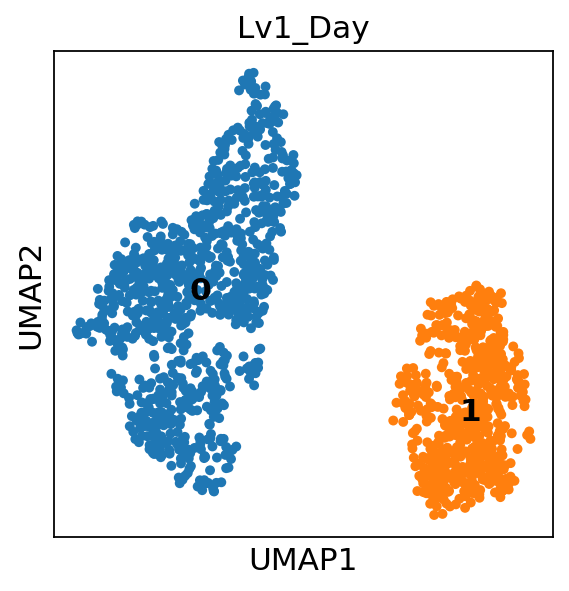

In [24]:
# Clustering
# Just to do a clustering for Day0 and Day3, and then remove the outlier cells
# This has been done and the analysis has been redone with excluding these 5 cells as outliers
# sc.tl.louvain(adata, resolution=0.1, key_added='Lv1_Day')
# sc.pl.umap(adata, color='Lv1_Day', legend_loc='on data')
# exCells = adata.obs_names[(adata.obs['Lv1_Day'] == '0') & (adata.obs['Day'] == '0hr')].values
# np.savetxt('exCells_in_wrong_cluster.txt', exCells, delimiter='\t', fmt='%s')

# Differential expression analysis

As many factors were included in the analysis, thus we need to use linear models to account for these effects. Here switch again to R for DESeq2 package.

The following comparisons will be done:

**BM+MPB:**

Day0 LT-HSC marker genes:
1. LT-HSC_Day0_NT vs the_rest
2. LT-HSC_Day0_NT vs ST-HSC_Day0_NT

**MPB:**

Day3 LT-HSC marker genes:
1. LT-HSC_Day3_NT vs the_rest

**MB:**
Day3 LT-HSC marker genes:
1. LT-HSC_Day3_GFP- vs rest

**BM+MPB:**

Day3 GFP+ vs Day3 GFP-:
1. Day3_GFP+PD- vs Day3_GFP-PD-
	- LT-HSC_Day3_GFP+PD- vs LT-HSC_Day3_GFP-PD-

**MPB only:**

Day3 GFP- vs Day3 NT:
1. Day3_GFP-PD- vs Day3_NT
	- LT-HSC_Day3_GFP-PD- vs LT-HSC_Day3_NT
	- ST-HSC_Day3_GFP-PD- vs ST-HSC_Day3_NT

**MPB only:**

Day3 GFP+ vs Day3 NT:
1. Day3_GFP+PD- vs Day3_NT
	- LT-HSC_Day3_GFP+PD- vs LT-HSC_Day3_NT
	- ST-HSC_Day3_GFP+PD- vs ST-HSC_Day3_NT
	- CD34_Day3_GFP+PD- vs CD34_Day3_NT

**MPB only:**

Day3 LT_PD+ vs Day3 LT_PD-:
1. LT_Day3_PD+ vs LT_Day3_PD-
	- LT-HSC_Day3_GFP+PD+ vs LT-HSC_Day3_GFP+PD-
	- LT-HSC_Day3_GFP-PD+ vs LT-HSC_Day3_GPF-PD-

Day3 vs Day0:
1. Day3 vs Day0

    **MPB only:**

	- Day3 NT vs Day0_NT
		- CD34_Day3_NT vs CD34_Day0_NT
	 	- LT-HSC_Day3_NT vs LT-HSC_Day0_NT
	 	- ST-HSC_Day3_NT vs ST-HSC_Day0_NT

    **BM only:**
    - Day3 GFP- vs Day0 NT
        - CD34_Day3_GFP- vs CD34_Day0_NT
        - LT-HSC_Day3_GFP- vs LT-HSC_Day0_NT
        - ST-HSC_Day3_GFP- vs ST-HSC_Day0_NT

In [2]:
%reload_ext rpy2.ipython

In [3]:
adata = sc.read('./write/MPB1234_raw.h5ad')
count = adata.X
GN = adata.var_names

In [4]:
adata = sc.read('./write/MPB1234_processed_new.h5ad')
con_sub1 = {'GFP+PD+': 'GFP_pos',
           'GFP+PD-': 'GFP_pos',
           'GFP-PD+': 'GFP_neg',
           'GFP-PD-': 'GFP_neg',
           'NT': 'NT'}

con_sub2 = {'GFP+PD+': 'PD_pos',
           'GFP+PD-': 'PD_neg',
           'GFP-PD+': 'PD_pos',
           'GFP-PD-': 'PD_neg',
           'NT': 'PD_neg'}

adata.obs['con_sub1'] = [con_sub1[x] for x in adata.obs['Condition'].values]
adata.obs['con_sub2'] = [con_sub2[x] for x in adata.obs['Condition'].values]

In [3]:
adata.write('./write/MPB1234_processed_new.h5ad')

... storing 'con_sub1' as categorical
... storing 'con_sub2' as categorical


In [5]:
meta = adata.obs

In [6]:
count = pd.DataFrame(count.transpose())
count.index = GN
count.columns = adata.obs_names

In [7]:
%%R -i count -i meta
source("./DESeq_source.R")

## Day0 LT-HSC marker genes ###########################################
print("Day0 LT-HSC marker genes")
g1 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "0hr" & meta$Condition == "NT"]
g2 <- meta$ID[meta$Cell_Type != "LT-HSC" & meta$Day == "0hr" & meta$Condition == "NT"]
print(length(g1))
print(length(g2))
LT_Day0_NTvsRest_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day0_NTvsRest_Day0_NT, "./LT_Day0_NTvsRest_Day0_NT")
saveRDS(LT_Day0_NTvsRest_Day0_NT, file="./LT_Day0_NTvsRest_Day0_NT.rds")
print(summary(LT_Day0_NTvsRest_Day0_NT))

## Day0 LT-HSC marker genes #################################################
print("Day0 LT-HSC marker genes")
g1 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "0hr" & meta$Condition == "NT"]
g2 <- meta$ID[meta$Cell_Type == "ST-HSC" & meta$Day == "0hr" & meta$Condition == "NT"]
print(length(g1))
print(length(g2))
LT_Day0_NTvsST_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day0_NTvsST_Day0_NT, "./LT_Day0_NTvsST_Day0_NT")
saveRDS(LT_Day0_NTvsST_Day0_NT, file="./LT_Day0_NTvsST_Day0_NT.rds")
print(summary(LT_Day0_NTvsST_Day0_NT))

## Day3 GFP+ vs Day3 GFP- #########################################################
print("Day3 GFP+ vs Day3 GFP-")
g1 <- meta$ID[meta$con_sub1 == "GFP_pos" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg"]
g2 <- meta$ID[meta$con_sub1 == "GFP_neg" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg"]
print(length(g1))
print(length(g2))
Day3_GFPposvsDay3_GFPneg <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch+Cell_Type")
saveDEresults(Day3_GFPposvsDay3_GFPneg, "./Day3_GFPposvsDay3_GFPneg")
saveRDS(Day3_GFPposvsDay3_GFPneg, file="./Day3_GFPposvsDay3_GFPneg.rds")
print(summary(Day3_GFPposvsDay3_GFPneg))

## Day3 GFP- vs Day3 NT ####################################################
print("Day3 GFP- vs Day3 NT")
g1 <- meta$ID[meta$con_sub1 == "GFP_neg" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg"]
g2 <- meta$ID[meta$con_sub1 == "NT" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg"]
print(length(g1))
print(length(g2))
Day3_GFPnegvsDay3_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch+Cell_Type")
saveDEresults(Day3_GFPnegvsDay3_NT, "./Day3_GFPnegvsDay3_NT")
saveRDS(Day3_GFPnegvsDay3_NT, file="./Day3_GFPnegvsDay3_NT.rds")
print(summary(Day3_GFPnegvsDay3_NT))

## Day3 GFP+ vs Day3 NT ########################################
print("Day3 GFP+ vs Day3 NT")
g1 <- meta$ID[meta$con_sub1 == "GFP_pos" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg"]
g2 <- meta$ID[meta$con_sub1 == "NT" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg"]
print(length(g1))
print(length(g2))
Day3_GFPposvsDay3_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch+Cell_Type")
saveDEresults(Day3_GFPposvsDay3_NT, "./Day3_GFPposvsDay3_NT")
saveRDS(Day3_GFPposvsDay3_NT, file="./Day3_GFPposvsDay3_NT.rds")
print(summary(Day3_GFPposvsDay3_NT))

## LT PD+ vs LT PD-
print("LT PD+ vs LT PD-")
g1 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "62hr" & meta$con_sub2 == "PD_pos" & meta$con_sub1 != "NT"]
g2 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$con_sub1 != "NT"]
print(length(g1))
print(length(g2))
LT_PDposvsLT_PDneg <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch+con_sub1")
saveDEresults(LT_PDposvsLT_PDneg, "./LT_PDposvsLT_PDneg")
saveRDS(LT_PDposvsLT_PDneg, file="./LT_PDposvsLT_PDneg.rds")
print(summary(LT_PDposvsLT_PDneg))

## Day3 NT vs Day0 NT
print("Day3 NT vs Day0 NT")
g1 <- meta$ID[meta$Day == "62hr" & meta$con_sub1 == "NT" & meta$con_sub2 != "PD_pos"]
g2 <- meta$ID[meta$Day == "0hr" & meta$con_sub1 == "NT" & meta$con_sub2 != "PD_pos"]
print(length(g1))
print(length(g2))
Day3vsDay0 <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch+Cell_Type")
saveDEresults(Day3vsDay0, "./Day3vsDay0")
saveRDS(Day3vsDay0, file="./Day3vsDay0.rds")
print(summary(Day3vsDay0))

[1] "LT PD+ vs LT PD-"
[1] 94
[1] 223


R[write to console]: Loading required package: DESeq2

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    o

[1] "Intercept"                   "n_genes"                    
[3] "batch_1_vs_0"                "batch_2_vs_0"               
[5] "batch_3_vs_0"                "con_sub1_GFP_pos_vs_GFP_neg"
[7] "condition_test_vs_control"  
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene               89  -none-       character
downGene            342  -none-       character
backgroundGeneSet 12513  -none-       character
[1] "Day3 NT vs Day0 NT"
[1] 243
[1] 598


R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

R[write to console]: estimating size fa

[1] "Intercept"                 "n_genes"                  
[3] "batch_1_vs_0"              "batch_2_vs_0"             
[5] "batch_3_vs_0"              "Cell_Type_LT.HSC_vs_CD34."
[7] "Cell_Type_ST.HSC_vs_CD34." "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene             1123  -none-       character
downGene            927  -none-       character
backgroundGeneSet 11269  -none-       character


In [7]:
%%R -i count -i meta
source("./DESeq_source.R")

## Day3 LT-HSC marker genes ###########################################
print("Day3 LT-HSC marker genes")
g1 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "62hr" & meta$Condition == "NT"]
g2 <- meta$ID[meta$Cell_Type != "LT-HSC" & meta$Day == "62hr" & meta$Condition == "NT"]
print(length(g1))
print(length(g2))
LT_Day3_NTvsRest_Day3_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day3_NTvsRest_Day3_NT, "./LT_Day3_NTvsRest_Day3_NT")
saveRDS(LT_Day3_NTvsRest_Day3_NT, file="./LT_Day3_NTvsRest_Day3_NT.rds")
print(summary(LT_Day3_NTvsRest_Day3_NT))

## Day3 GFP+ vs Day3 GFP- sub ####################################
print("Day3 LT GFP+ vs Day3 LT GFP-")
g1 <- meta$ID[meta$con_sub1 == "GFP_pos" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="LT-HSC"]
g2 <- meta$ID[meta$con_sub1 == "GFP_neg" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="LT-HSC"]
print(length(g1))
print(length(g2))
LT_Day3_GFPposvsLT_Day3_GFPneg <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day3_GFPposvsLT_Day3_GFPneg, "./LT_Day3_GFPposvsLT_Day3_GFPneg")
saveRDS(LT_Day3_GFPposvsLT_Day3_GFPneg, file="./LT_Day3_GFPposvsLT_Day3_GFPneg.rds")
print(summary(LT_Day3_GFPposvsLT_Day3_GFPneg))

## Day3 GFP- vs Day3 NT sub ####################################
print("Day3 LT GFP- vs Day3 LT NT")
g1 <- meta$ID[meta$con_sub1 == "GFP_neg" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="LT-HSC"]
g2 <- meta$ID[meta$con_sub1 == "NT" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="LT-HSC"]
print(length(g1))
print(length(g2))
LT_Day3_GFPnegvsLT_Day3_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day3_GFPnegvsLT_Day3_NT, "./LT_Day3_GFPnegvsLT_Day3_NT")
saveRDS(LT_Day3_GFPnegvsLT_Day3_NT, file="./LT_Day3_GFPnegvsLT_Day3_NT.rds")
print(summary(LT_Day3_GFPnegvsLT_Day3_NT))

print("Day3 ST GFP- vs Day3 ST NT")
g1 <- meta$ID[meta$con_sub1 == "GFP_neg" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="ST-HSC"]
g2 <- meta$ID[meta$con_sub1 == "NT" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="ST-HSC"]
print(length(g1))
print(length(g2))
ST_Day3_GFPnegvsST_Day3_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(ST_Day3_GFPnegvsST_Day3_NT, "./ST_Day3_GFPnegvsST_Day3_NT")
saveRDS(ST_Day3_GFPnegvsST_Day3_NT, file="./ST_Day3_GFPnegvsST_Day3_NT.rds")
print(summary(ST_Day3_GFPnegvsST_Day3_NT))

## Day3 GFP+ vs Day3 NT sub #####################################
print("Day3 LT GFP+ vs Day3 LT NT")
g1 <- meta$ID[meta$con_sub1 == "GFP_pos" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="LT-HSC"]
g2 <- meta$ID[meta$con_sub1 == "NT" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="LT-HSC"]
print(length(g1))
print(length(g2))
LT_Day3_GFPposvsLT_Day3_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day3_GFPposvsLT_Day3_NT, "./LT_Day3_GFPposvsLT_Day3_NT")
saveRDS(LT_Day3_GFPposvsLT_Day3_NT, file="./LT_Day3_GFPposvsLT_Day3_NT.rds")
print(summary(LT_Day3_GFPposvsLT_Day3_NT))

print("Day3 ST GFP+ vs Day3 ST NT")
g1 <- meta$ID[meta$con_sub1 == "GFP_pos" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="ST-HSC"]
g2 <- meta$ID[meta$con_sub1 == "NT" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="ST-HSC"]
print(length(g1))
print(length(g2))
ST_Day3_GFPposvsST_Day3_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(ST_Day3_GFPposvsST_Day3_NT, "./ST_Day3_GFPposvsST_Day3_NT")
saveRDS(ST_Day3_GFPposvsST_Day3_NT, file="./ST_Day3_GFPposvsST_Day3_NT.rds")
print(summary(ST_Day3_GFPposvsST_Day3_NT))

print("Day3 CD34 GFP+ vs Day3 CD34 NT")
g1 <- meta$ID[meta$con_sub1 == "GFP_pos" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="CD34+"]
g2 <- meta$ID[meta$con_sub1 == "NT" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$Cell_Type=="CD34+"]
print(length(g1))
print(length(g2))
CD34_Day3_GFPposvsCD34_Day3_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(CD34_Day3_GFPposvsCD34_Day3_NT, "./CD34_Day3_GFPposvsCD34_Day3_NT")
saveRDS(CD34_Day3_GFPposvsCD34_Day3_NT, file="./CD34_Day3_GFPposvsCD34_Day3_NT.rds")
print(summary(CD34_Day3_GFPposvsCD34_Day3_NT))

## Day3 LT_PD+ vs Day3 LT_PD- sub #############################
print("LT GFP+ PD+ vs LT GFP+ PD-")
g1 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "62hr" & meta$con_sub2 == "PD_pos" & meta$con_sub1 == "GFP_pos"]
g2 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$con_sub1 == "GFP_pos"]
print(length(g1))
print(length(g2))
LT_GFPpos_PDposvsLT_GFPpos_PDneg <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_GFPpos_PDposvsLT_GFPpos_PDneg, "./LT_GFPpos_PDposvsLT_GFPpos_PDneg")
saveRDS(LT_GFPpos_PDposvsLT_GFPpos_PDneg, file="./LT_GFPpos_PDposvsLT_GFPpos_PDneg.rds")
print(summary(LT_GFPpos_PDposvsLT_GFPpos_PDneg))

print("LT GFP- PD+ vs LT GFP- PD-")
g1 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "62hr" & meta$con_sub2 == "PD_pos" & meta$con_sub1 == "GFP_neg"]
g2 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "62hr" & meta$con_sub2 == "PD_neg" & meta$con_sub1 == "GFP_neg"]
print(length(g1))
print(length(g2))
LT_GFPneg_PDposvsLT_GFPneg_PDneg <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes")
saveDEresults(LT_GFPneg_PDposvsLT_GFPneg_PDneg, "./LT_GFPneg_PDposvsLT_GFPneg_PDneg")
saveRDS(LT_GFPneg_PDposvsLT_GFPneg_PDneg, file="./LT_GFPneg_PDposvsLT_GFPneg_PDneg.rds")
print(summary(LT_GFPneg_PDposvsLT_GFPneg_PDneg))

## Day3 NT vs Day0 NT sub ############################################
print("LT Day3 NT vs LT Day0 NT")
g1 <- meta$ID[meta$Day == "62hr" & meta$con_sub1 == "NT" & meta$con_sub2 != "PD_pos" & meta$Cell_Type=="LT-HSC"]
g2 <- meta$ID[meta$Day == "0hr" & meta$con_sub1 == "NT" & meta$con_sub2 != "PD_pos" & meta$Cell_Type=="LT-HSC"]
print(length(g1))
print(length(g2))
LT_Day3_NTvsLT_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day3_NTvsLT_Day0_NT, "./LT_Day3_NTvsLT_Day0_NT")
saveRDS(LT_Day3_NTvsLT_Day0_NT, file="./LT_Day3_NTvsLT_Day0_NT.rds")
print(summary(LT_Day3_NTvsLT_Day0_NT))

print("ST Day3 NT vs ST Day0 NT")
g1 <- meta$ID[meta$Day == "62hr" & meta$con_sub1 == "NT" & meta$con_sub2 != "PD_pos" & meta$Cell_Type=="ST-HSC"]
g2 <- meta$ID[meta$Day == "0hr" & meta$con_sub1 == "NT" & meta$con_sub2 != "PD_pos" & meta$Cell_Type=="ST-HSC"]
print(length(g1))
print(length(g2))
ST_Day3_NTvsST_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(ST_Day3_NTvsST_Day0_NT, "./ST_Day3_NTvsST_Day0_NT")
saveRDS(ST_Day3_NTvsST_Day0_NT, file="./ST_Day3_NTvsST_Day0_NT.rds")
print(summary(ST_Day3_NTvsST_Day0_NT))

print("CD34 Day3 NT vs CD34 Day0 NT")
g1 <- meta$ID[meta$Day == "62hr" & meta$con_sub1 == "NT" & meta$con_sub2 != "PD_pos" & meta$Cell_Type=="CD34+"]
g2 <- meta$ID[meta$Day == "0hr" & meta$con_sub1 == "NT" & meta$con_sub2 != "PD_pos" & meta$Cell_Type=="CD34+"]
print(length(g1))
print(length(g2))
CD34_Day3_NTvsCD34_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(CD34_Day3_NTvsCD34_Day0_NT, "./CD34_Day3_NTvsCD34_Day0_NT")
saveRDS(CD34_Day3_NTvsCD34_Day0_NT, file="./CD34_Day3_NTvsCD34_Day0_NT.rds")
print(summary(CD34_Day3_NTvsCD34_Day0_NT))

[1] "LT GFP- PD+ vs LT GFP- PD-"
[1] 37
[1] 80


R[write to console]: Loading required package: DESeq2

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    o

[1] "Intercept"                 "n_genes"                  
[3] "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene              103  -none-       character
downGene            378  -none-       character
backgroundGeneSet 12038  -none-       character
[1] "LT Day3 NT vs LT Day0 NT"
[1] 75
[1] 218


R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was a

[1] "Intercept"                 "n_genes"                  
[3] "batch_1_vs_0"              "batch_2_vs_0"             
[5] "batch_3_vs_0"              "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene              550  -none-       character
downGene            360  -none-       character
backgroundGeneSet 11525  -none-       character
[1] "ST Day3 NT vs ST Day0 NT"
[1] 71
[1] 171


R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was a

[1] "Intercept"                 "n_genes"                  
[3] "batch_1_vs_0"              "batch_2_vs_0"             
[5] "batch_3_vs_0"              "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene              281  -none-       character
downGene            329  -none-       character
backgroundGeneSet 10780  -none-       character
[1] "CD34 Day3 NT vs CD34 Day0 NT"
[1] 97
[1] 209


R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was a

[1] "Intercept"                 "n_genes"                  
[3] "batch_1_vs_0"              "batch_2_vs_0"             
[5] "batch_3_vs_0"              "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene              868  -none-       character
downGene            574  -none-       character
backgroundGeneSet 11188  -none-       character
